# What characteristics correlate with Voting Rate
A friend of mine running for the local council has procured the voter registration data for the area and shared it with me. Here is an initial investigation of voter characteristics and how they correlate with Voting Rate.

Prior to this analysis the data has been cleaned, all personally identifying data removed and some additional featured created by manipulating the available information.

In [1]:
# imports
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, Markdown
import statsmodels.stats.proportion as props
import scipy.stats as st

from modules.lv_utils import load_households
from modules.lv_utils import load_voters

In [2]:
# load the data
households = load_households('data_clean/20180725_fullset_households_district3.csv')
voters = load_voters('data_clean/20180725_fullset_voters_district3.csv')
elections = pd.read_csv('data_clean/20180621_election_data.csv')

# set parameters for vote rate columns for the individual and household levels
cols_vr = ['E34_nVotesPct', 'E56_nVotesPct', 'E78_nVotesPct']
cols_vr_hh = ['E34_nVotesPctInHH','E56_nVotesPctInHH','E78_nVotesPctInHH']

In [3]:
# a couple of constants
outcols = ['votes_s0','elec_n0','rate_r0','votes_s1','elec_n1','rate_r1','emp_diff', 'calc_z', 'calc_p','perm_p']
perm_iterations = 10000
ap = {'arrowstyle':'->', 'color':'gray'}

Defining various methods and functions used to present the data.

In [4]:
def clean_df(df, fields, vrates):
    """
    Returns the voter rate columns with Nan not -1
    and fields in fields have missing values replaced with NaNs.
    """
    # converting cleaned not known data ie 'UNK' to NaNs
    for f in fields:
        # replacing 'UNK' with Nan to indicate no data if fields has any 'UNK'
        if 'UNK' in df.loc[:,f].value_counts().index.values.astype(str):
            df.loc[:,f].replace('UNK', np.NaN, inplace=True)
    
    # replacing '-1' indicating no data for vote with NaN
    for c in df[vrates]:
        df[c].replace(-1, np.NaN, inplace=True)
        
    return df

In [5]:
def show_vote_rate_and_summary(df, lab, title):
    """
    Draws the horizontal histograms for the data provided in df '_nVotesPct' in columns one per hist required.
    labels for each data column and a title are passed in and used.
    """
    vrs = df.columns
    n_plt = len(vrs)
    
    fig, axes = plt.subplots(n_plt, 1, sharex=True, figsize=(20,n_plt*2))
    
    # Vote in every election, or 5/6 then you're in the top Always vote' category
    # Vote in 1/2, 2/4, 3/6, 3/5 or 2/5 then in the middle category
    # Vote in no election or 1/6 then in the bottom 'Never vote' category
    edges = [0, 0.19, 0.39, 0.61, 0.81, 1]

    n = [0 for i in range(n_plt)]
    for i,(e,l) in enumerate(zip(vrs,lab)):
        # drawing the graph
        _ = axes[i].hist(df[e].dropna(), density=True, bins=edges, orientation='horizontal',
                         label=l, alpha=0.7)
        # calculating the bucket counts
        n[i], _ = np.histogram(df[e].dropna(), bins=edges)
    for i,ax in enumerate(axes):
        ax.legend(loc='center right')
        ax.annotate('Voters who always Vote', xy=[1,0.8], xytext=[1.1,0.61], arrowprops=ap, color='gray')
        ax.annotate('Voters who never Vote', xy=[1,0.2], xytext=[1.1,0.29], arrowprops=ap, color='gray')

    ylab = 'Vote Rate in last 6 elections'
    axes[n_plt-1].set_xlabel('Probability Density Function (PDF)')
    _ = axes[0].set_title(title)
    _ = axes[0].set_ylabel(ylab)
    _ = axes[0].yaxis.set_label_coords(-0.03, -0.05*n_plt)
    plt.show()
    
    # calculating and displaying the summary table
    order =['Never','Under Half','Half','Over Half','Always']
    dw = pd.DataFrame(n, columns=order, index=lab).transpose()
    dw2 = pd.DataFrame()
    for e in lab:
        dw2[e+'_pct'] = round(dw[e]/sum(dw[e]),3) * 100
    dw = pd.concat([dw, dw2], keys=('Number of Voters','Voters as a %'), axis=1)
    dw = dw.loc[order[::-1],:]
    dw.loc['Totals'] = dw.sum(axis=0)
    dw['Number of Voters'] = dw['Number of Voters'].astype('int')
    display(dw)
    return dw

In [6]:
def plot_hist_vote_rate_vs_field(ax, df, voteRatef, field, bins):
    """
    Spliting the provided data into sometimes, always and never voters and drawing 
    a histogram of the three vote categories on the provided axis.
    """
    a, b = 0.3, bins
    df1 = pd.DataFrame(df[[voteRatef, field]]).rename(columns = {voteRatef:'VR'})
    always, sometimes, never, allv = (df1.VR == 1), (df1.VR < 1) & (df1.VR > 0), (df1.VR == 0), (df1.VR.notnull())
    
    rs,_,_ = ax.hist(df1.loc[sometimes, field], bins=b, alpha=a, label='SomeTimesVoters')
    ra,_,_ = ax.hist(df1.loc[always, field], bins=b, alpha=a, label='AlwaysVoters')
    rn,_,_ = ax.hist(df1.loc[never, field], bins=b, alpha=a, label='NeverVoters')
    rt,_,_ = ax.hist(df1.loc[allv, field], bins=b, alpha=a, label='Total #', histtype='step')
    
    ax.legend(loc='upper left')
    return ax,[ra,rs,rn,rt]

In [7]:
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_replicates[i] = func(np.random.choice(data, size=len(data)))
    return bs_replicates

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

In [8]:
def bs_ts_diff_of_means_test(d1, d2):
    """
    Run a bootstrap diff of means test between the two provided dataframes
    ploting an ecdf and histogram of the bootstrap replicates created
    """
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,3))

    # Compute values for and plot ECDFs
    x_d1, y_d1 = ecdf(d1)
    x_d2, y_d2 = ecdf(d2)
    ax1.plot(x_d1, y_d1, marker='.', linestyle='none')
    ax1.plot(x_d2, y_d2, marker='.', linestyle='none')

    # Label and show plot
    ax1.margins(0.02)
    ax1.legend(('always vote', 'never vote'), loc='lower right')
    ax1.set_xlabel('age of voter')
    ax1.set_ylabel('ECDF')
    
    # Compute the difference in two samples
    diff_means = np.mean(d1) - np.mean(d2)
    print('Empirical difference in mean age observed: {:.0f}-{:.0f}={:.3} years'.format(
        np.mean(d1),np.mean(d2),diff_means))

    # Compute mean of pooled data: mean_count
    mean_count = np.mean(np.concatenate((d1, d2)))

    # Generate shifted data sets
    av_shifted = d1 - np.mean(d1) + mean_count
    nv_shifted = d2 - np.mean(d2) + mean_count

    # Generate bootstrap replicates using shifted data
    bs_reps_av = draw_bs_reps(av_shifted, np.mean, size=10000)
    bs_reps_nv = draw_bs_reps(nv_shifted, np.mean, size=10000)

    # Get replicates of difference of means: bs_replicates
    bs_replicates = bs_reps_av - bs_reps_nv
    
    _ = ax2.hist(bs_replicates, density=True, bins=100)
    _ = ax2.axvline(diff_means, color='red')
    _ = ax2.set_xlabel('Test-statistic ({})'.format('Diff of means'))
    _ = ax2.set_ylabel('PDF')
    plt.show()

    # Compute and print p-value: p
    p = np.sum(bs_replicates <= np.mean(d1) - np.mean(d2))/ len(bs_replicates)
    print('p-value =', p)

In [9]:
def get_two_sample_ns(d0,d1):
    """
    Calculate the number of elections and successes as well as the percent success rate 
    for the two provided dataframes. '_nVotesPos' and '_nVotes' columns are expected.
    """
    nVotesPos = [c for c in d0.columns if 'nVotesPos' in c][0]
    nVotes = nVotesPos[:-3]
    n0, s0 = d0[nVotesPos].sum(), d0[nVotes].sum()
    n1, s1 = d1[nVotesPos].sum(), d1[nVotes].sum()
    return s0,n0,(100*s0/n0),s1,n1,(100*s1/n1)

In [10]:
def diff_frac_votes(d0, d1):
    """Compute the difference in fraction of votes. 
    Input two data frames with the nVotesPos and nVotes fields for election(s) of interest"""
    [s0,n0,_,s1,n1,_] = get_two_sample_ns(d0, d1)
    #print('diff frac votes:{}'.format((s0 / n0) - (s1 / n1)))
    return (s0 / n0) - (s1 / n1)

def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""
    data = pd.concat((data1, data2))
    permuted_data = data.sample(frac=1)
    return permuted_data[:len(data1)], permuted_data[len(data1):]

def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""
    perm_replicates = np.empty(size)
    for i in range(size):
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)
        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)
    return perm_replicates

In [11]:
def two_sample_perm_test_diff_frac_votes(d0, d1, ax, lbl, tail=1):
    """Complete a two sample permutation test using difference in fraction of votes as test statistic"""
    
    # Compute the test statistic from experimental data: empirical_diff_means
    empirical_diff_frac_votes = diff_frac_votes(d0, d1)

    # Draw 10,000 permutation replicates: perm_replicates
    perm_replicates = draw_perm_reps(d0, d1, diff_frac_votes, size=perm_iterations)
    
    # Plot test statistic histogram
    _ = ax.hist(perm_replicates, density=True, bins=1000)
    _ = ax.axvline(empirical_diff_frac_votes, color='red')
    _ = ax.set_xlabel('Difference in vote rate for category')
    _ = ax.set_ylabel('PDF')
    _ = ax.set_title('For {}'.format(lbl))

    # Compute p-value: p
    p = np.sum(perm_replicates >= empirical_diff_frac_votes) / len(perm_replicates)
    if p >0.5:
        p = 1-p
    
    lmt = 0.01 if tail == 1 else 0.005
    [nn_ll, nn_ul] = np.percentile(perm_replicates, [lmt*100,(1-lmt)*100])
    
    _ = ax.axvline(nn_ll, color='orange', ls='--')
    _ = ax.axvline(nn_ul, color='orange', ls='--')

    ar_ht = ax.get_ylim()[1]*0.9
    tx_x = -np.abs(nn_ul)+0.5*np.std(perm_replicates)
    text = '{} tail 99% Conf ({:.3f} : {:.3f})'.format(tail, nn_ll, nn_ul)
    ax.annotate(text, xy=[nn_ul,ar_ht*0.7], xytext=[tx_x,ar_ht], color='w', alpha=0, arrowprops=ap)
    ax.annotate(text, xy=[nn_ll,ar_ht*0.7], xytext=[tx_x,ar_ht], color='gray', arrowprops=ap)

    return p, empirical_diff_frac_votes, ax

## All Voters in our dataset

In [12]:
display(Markdown('Our data covers one district, containing information about **{}** Voters and **{}** Households.'.format(
        voters.shape[0], households.shape[0])))

Our data covers one district, containing information about **13307** Voters and **6930** Households.

To illuminate voting behavior, the vote rate was Calculated on a scale of 0-1. Our data lets us know if a particular voter was registered to vote in a particular election (ie could have possibly voted) and then also if they did actually vote in that election. If a voter voted in all elections they could have voted in then their vote rate is 1 and they 'always' voted, if they didn't vote in any of the elections they were registered for then their vote rate is 0 and they 'never' voted, numbers in between indicate that the voter voted in some of the elections they could have done but not all of them, higher is more likely.

We have data on 6 elections:
- E1 the primary held on $5^{th}$ June 2012
- E2 the general held on $6^{th}$ November 2012 - this was a presidential election
- E3 the primary held on $3^{rd}$ June 2014
- E4 the general held on $4^{th}$ November 2014 - this was a congressional election
- E5 the primary held on $7^{th}$ June 2016
- E6 the general held on $8^{th}$ November 2016 - this was a presidential election

Not all currently registered voters were also registered in this same district in 2012, and conversely we only have data from 2012 from voters who are still registered in this district. The data about 2012 voting habits has, as expected, therefore the smallest number of data points.

# Single elections - How many people vote?

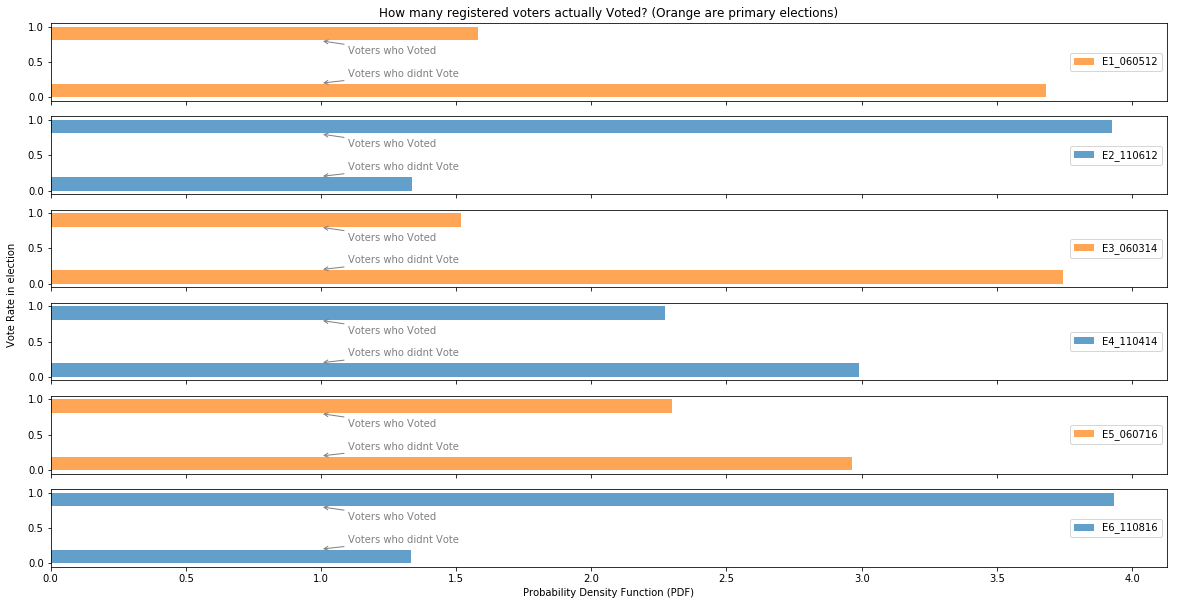

Number of Voters                                                    \
               E1_060512 E2_110612 E3_060314 E4_110414 E5_060716 E6_110816   
Voted               2577      6937      2807      4314      4846      9220   
Skipped             6000      2359      6920      5673      6255      3122   
Totals              8577      9296      9727      9987     11101     12342   

        Voters as a %                                     
               E1_pct E2_pct E3_pct E4_pct E5_pct E6_pct  
Voted            30.0   74.6   28.9   43.2   43.7   74.7  
Skipped          70.0   25.4   71.1   56.8   56.3   25.3  
Totals          100.0  100.0  100.0  100.0  100.0  100.0

In [13]:
ev = ['E1_nVotesPct','E2_nVotesPct','E3_nVotesPct','E4_nVotesPct','E5_nVotesPct','E6_nVotesPct']
lab = ['E6_110816', 'E5_060716','E4_110414', 'E3_060314', 'E2_110612', 'E1_060512']

df_e = clean_df(voters.loc[:,ev],[],ev)

fig, axes = plt.subplots(6,1, sharex=True, figsize=(20,10))
edges = [0, 0.19, 0.39, 0.61, 0.81, 1]

n = [0 for i in range(6)]
for i,(e,l) in enumerate(zip(ev,lab[::-1])):
    col = 'tab:blue' if '11' in l else 'tab:orange'
    # drawing the graph
    _ = axes[i].hist(df_e[e].dropna(), density=True, bins=edges, orientation='horizontal',
                     label=l, alpha=0.7, color=col)
    # calculating the bucket counts
    n[i], _ = np.histogram(df_e[e].dropna(), bins=edges)

ap = {'arrowstyle':'->', 'color':'gray'}
for i,ax in enumerate(axes):
    ax.legend(loc='center right')
    ax.annotate('Voters who Voted', xy=[1,0.8], xytext=[1.1,0.61], arrowprops=ap, color='gray')
    ax.annotate('Voters who didnt Vote', xy=[1,0.2], xytext=[1.1,0.29], arrowprops=ap, color='gray')
     
title = 'Vote Rate in election'
axes[5].set_xlabel('Probability Density Function (PDF)')
_ = axes[0].set_title('How many registered voters actually Voted? (Orange are primary elections)')
_ = axes[0].set_ylabel(title)
_ = axes[0].yaxis.set_label_coords(-0.03, -2.5)
plt.show()

# calculating and displaying the summary table
order =['Skipped','Under Half','Half','Over Half','Voted']
dw = pd.DataFrame(n, columns=order, index=lab[::-1]).transpose()
dw2 = pd.DataFrame()
for e in lab[::-1]:
        dw2[e[:2]+'_pct'] = round(dw[e]/sum(dw[e]),3) * 100
dw = pd.concat([dw, dw2], keys=('Number of Voters','Voters as a %'), axis=1)
#dw = dw.drop(dw[dw.sum(axis='columns') <1].index)
dw = dw.loc[['Voted', 'Skipped'],:]
dw.loc['Totals'] = dw.sum(axis=0)
dw['Number of Voters'] = dw['Number of Voters'].astype('int')
dw

Looking at these graphs you can see we get highest turnout $\approx 70\%$ of registered voters for presidential General elections, while only seeing a $\approx 43\%$ turnout for the congressional general election in 2014.

Primaries have a much lower vote rate that their general elections $\approx 28-43\%$ although we saw a large turnout for the most recent 2016 primary $43.7\%$, in fact it was just larger than the prior congressional year general election $43.2\%$!

### Are they representative?

In order to validate our observed data I decided to run a two tailed one sample Z test comparing our observed vote rate to that published by the US Census Bureau for the 2016 Presidential Election. [Date available here](https://www.census.gov/newsroom/blogs/random-samplings/2017/05/voting_in_america.html) reports that $61.4\%$ of voting-age population reported voting.

Statistically testing with a one sample z test (calculated using proportions_ztest())
- Null hypothesis: our observed vote rate is the same as the reported rate of 61.4%
- Alt hypothesis: our observation is different

alpha = 0.01

In [14]:
n, s = voters.E6_nVotesPos.sum(), voters.E6_nVotes.sum()
display(Markdown('Our observed vote rate is: ${} / {}={:.0f}\%$'.format(s,n,100*s/n)))
(z, p) = props.proportions_ztest(s, n, value=0.614, alternative='two-sided')
display(Markdown('Test statistic (calculated using proportions_ztest()): ${:.4}$'.format(z)))
display(Markdown('P value: ${:.6}$'.format(p)))

Our observed vote rate is: $9220 / 12342=75\%$

Test statistic (calculated using proportions_ztest()): $34.0$

P value: $2.17925e-253$

This tiny p value is way below the 99% confidence level I selected so I must reject the null hypothesis and conclude that it is highly unlikely that the voters in my particular district are representative of the general US voting population at large. This is not really a surprising result given the geographical co-location of my data. Lets see what other voting characteristics do hold.

# Over all how much more do people vote in General elections than Primaries?

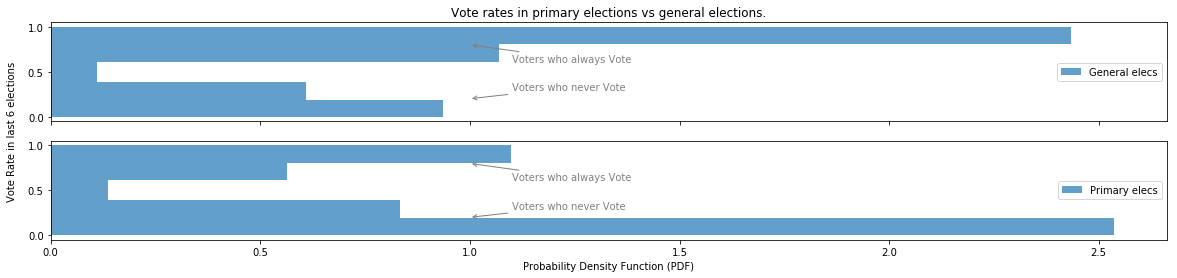

Number of Voters                   Voters as a %                  
              General elecs Primary elecs General elecs_pct Primary elecs_pct
Always                 5725          2334              46.3              20.9
Over Half              2647          1260              21.4              11.3
Half                    298           337               2.4               3.0
Under Half             1506          1862              12.2              16.7
Never                  2200          5384              17.8              48.2
Totals                12376         11177             100.1             100.1

In [15]:
vrs = ['Eag_nVotesPct','Eap_nVotesPct',]
df_w = clean_df(voters.loc[:,vrs], [], vrs)
title = 'Vote rates in primary elections vs general elections.'
df = show_vote_rate_and_summary(df_w, ['General elecs','Primary elecs'], title)

### Is this a real difference?
I'm going to calculate statistical significance using the number of possible votes cast across the elections of interest as our total n and the proportion of those where votes were in fact cast as the success proportion or s. This will ensure that we keep a direct link between success' and n number of trials when calculating our p values.

I've calculated statistical significance with two tests - the first a automated two sample proportion ztest (props.proportions_ztest()) - this test is possibly not appropriate to use as our sample size is larger than 10% of the total population. So I also calculated an estimated p based on a two sample permutation test.

- Null hypothesis: the true vote rate for primaries and general elections is actually the same
- Alt hypothesis: the vote rates are different

Significance level: 0.01 or 99% confidence

The zero p-value from both tests shown below requires us to reject the null hypothesis. Our data strongly supports that the underlying voter rate is lower in primary elections than general elections.

,votes_s0,elec_n0,rate_r0,votes_s1,elec_n1,rate_r1,emp_diff,calc_z,calc_p,perm_p
All primary vs general elections,10230,29405,34.79,20471,31625,64.7304,-29.9404,-73.918,0,0


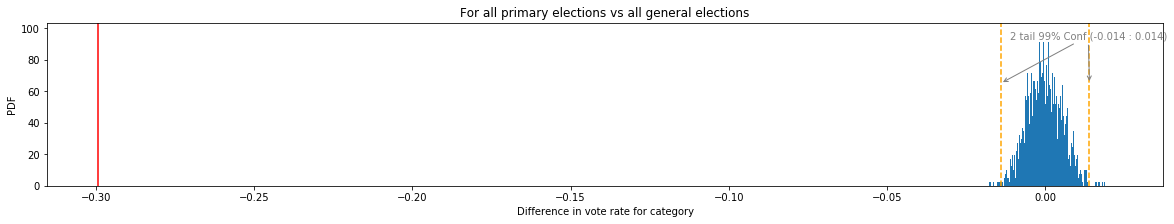

In [16]:
dx = voters[['Eap_nVotesPos', 'Eap_nVotes']]
dy = voters[['Eag_nVotesPos', 'Eag_nVotes']].rename(columns={'Eag_nVotesPos':'Eap_nVotesPos',
                                                             'Eag_nVotes':'Eap_nVotes'})
fig, axes = plt.subplots(figsize=(20,3))

df = pd.DataFrame(columns=outcols)
sx,nx,rx,sy,ny,ry = get_two_sample_ns(dx, dy)
cz,cp = props.proportions_ztest([sx,sy], [nx,ny], alternative='two-sided')
pp, emp_diff, axes = two_sample_perm_test_diff_frac_votes(dx,dy,axes,
                                                         'all primary elections vs all general elections', tail=2)   
df.loc['All primary vs general elections',outcols] = [sx,nx,rx,sy,ny,ry,emp_diff*100,cz,cp,pp]

display(df)
plt.show()

# How does Age affect vote rate (aka BirthYear)

In [17]:
vs, f = ['E12_nVotesPct','E14_nVotesPct','E16_nVotesPct'],['BirthYear']
df = clean_df(voters.loc[:,vs + f], f, vs)

old = df.BirthYear < 1901
young = df.BirthYear > 1995
#print(df[old | young].BirthYear.value_counts().sort_index())
display(Markdown('There are {} people over 100 (inc {} people entering 1900 which is likely bad data)'.format(
df[df.BirthYear < 1918].BirthYear.count(),df[df.BirthYear == 1900].BirthYear.count())))
display(Markdown('As you would expect some people ({}) register as they turn 18'.format(
df[df.BirthYear == 2000].BirthYear.count())))

display(Markdown('\nThe {} voters who have 1900 entered for their BirthYears have been removed'.format(
df[old].BirthYear.count())))
# cutting out the outliers
df = df[~old]

There are 12 people over 100 (inc 7 people entering 1900 which is likely bad data)

As you would expect some people (32) register as they turn 18


The 7 voters who have 1900 entered for their BirthYears have been removed

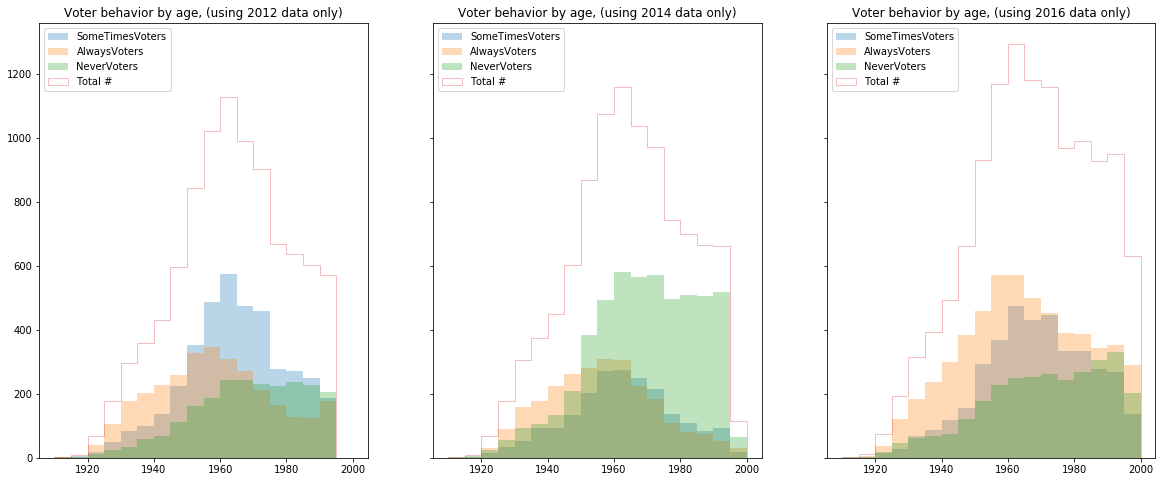

In [18]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, sharey=True, figsize=(20,8))
d = [0 for i in range(3)]
bins = [c for c in range(1910, 2001, 5)]

ax1, d[0] = plot_hist_vote_rate_vs_field(ax1, df, 'E12_nVotesPct', 'BirthYear', bins)
ax1.set_title('Voter behavior by age, (using 2012 data only)')

ax2, d[1] = plot_hist_vote_rate_vs_field(ax2, df, 'E14_nVotesPct', 'BirthYear', bins)
ax2.set_title('Voter behavior by age, (using 2014 data only)')

ax3, d[2] = plot_hist_vote_rate_vs_field(ax3, df, 'E16_nVotesPct', 'BirthYear', bins)
ax3.set_title('Voter behavior by age, (using 2016 data only)')

plt.show()

You can see in these histograms that the Always Voters skew older (having birth years to the left of the graphs) and the Never Voters skew younger with birth years to the right of the graphs. This is a particularly strong effect in the Congressional year of 2014.

You can also see that the young are less likely to have registered to vote in the first place as the total voter histograms all show a peak around birth year 1960. Its also possible that this effect is caused not by younger voters not registering but by our district having fewer younger voters living here. It is also plausible that younger voters are more mobile and so even if they were here for the 2012 or 2014 vote they have since moved out of the district and so dropped out of our data set and you can't forget that there may just be more people born in the 1960's.

### Is this a real difference?

Statistically testing with a bootstrapped two sample test of the means of each group, I'm using bootstrapping as it avoids the issue of our sample being more than 10% of the total population of our district.
- Null hypothesis: the average age of never voters and always voters is the same
- Alt hypothesis: the average age of never voters is lower than the average of always voters

Significance level: 0.01

The zero p-value shown below requires us to reject the null hypothesis. Our data strongly supports that the average age of never voters is lower than the average age of always voters rate.


Calculating p-value for difference in mean age of voters during 2012

Empirical difference in mean age observed: 1958-1968=-10.1 years


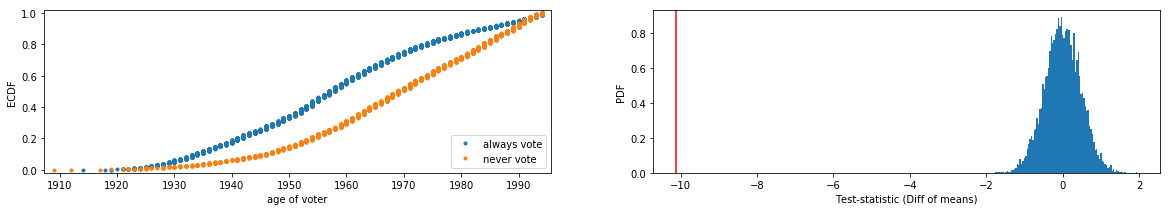

p-value = 0.0

Calculating p-value for difference in mean age of voters during 2014

Empirical difference in mean age observed: 1956-1969=-12.9 years


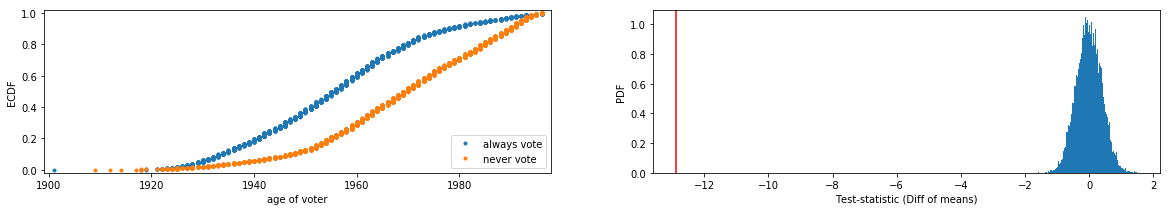

p-value = 0.0

Calculating p-value for difference in mean age of voters during 2016

Empirical difference in mean age observed: 1964-1971=-6.29 years


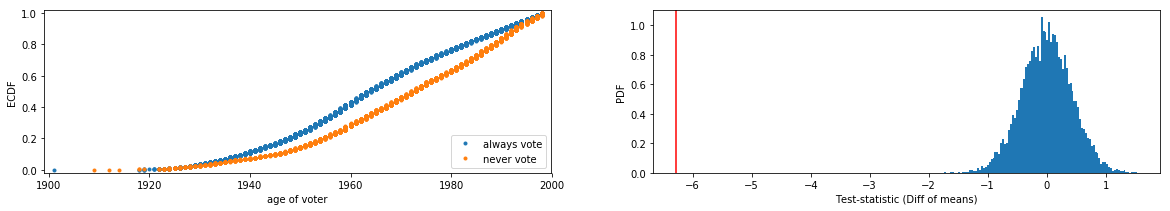

p-value = 0.0


In [19]:
years = [('E12','2012'),('E14','2014'),('E16','2016')]
for (y, lbl) in years:
    d1 = df.loc[(df[y + '_nVotesPct'] == 1),['BirthYear']].BirthYear
    d2 = df.loc[(df[y + '_nVotesPct'] == 0),['BirthYear']].BirthYear
    print('\nCalculating p-value for difference in mean age of voters during {}\n'.format(lbl))
    bs_ts_diff_of_means_test(d1,d2)

## Grouping the voters by hasParty

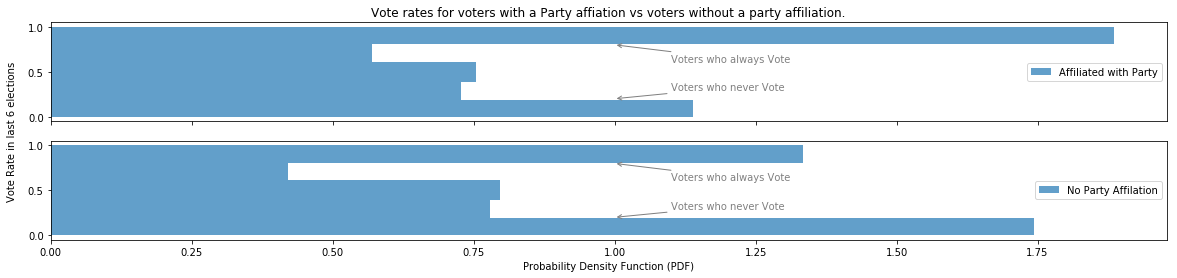

Number of Voters                      \
           Affiliated with Party No Party Affilation   
Always                      3074                 962   
Over Half                    977                 319   
Half                        1426                 665   
Under Half                  1248                 591   
Never                       1859                1257   
Totals                      8584                3794   

                       Voters as a %                          
           Affiliated with Party_pct No Party Affilation_pct  
Always                          35.8                    25.4  
Over Half                       11.4                     8.4  
Half                            16.6                    17.5  
Under Half                      14.5                    15.6  
Never                           21.7                    33.1  
Totals                         100.0                   100.0

In [20]:
vs, f = ['E78_nVotesPct'],['HasParty']
df_w = clean_df(voters.loc[:,vs + f], f, vs)
( _, d1 ), ( _, d0 ) = df_w.groupby(['HasParty'])
df_w = pd.DataFrame({'HasParty':d0[vs[0]],'NoParty':d1[vs[0]]})
title = 'Vote rates for voters with a Party affiation vs voters without a party affiliation.'
df = show_vote_rate_and_summary(df_w, ['Affiliated with Party','No Party Affilation'], title)

You can see that blue (noParty) bars are taller on the never vote row while the (hasParty) bars are taller on the always vote row. Looking at bar sizes you can see that a voter with an a party affiliation is ~10% more likely to be an always voter group and ~12% less likely to be a never voter. 

Note for this analysis hasParty flag people with 'UNK' party affiliation were marked 'False' or noParty.

### Is this a real effect?
Statisticaly testing with a two sample z test (calculated using proportions_ztest()) and with a permutation test. The permutation test is likely more appropriate as we have a sample size that is over $10\%$ of the total population.

- H0: The vote rate of people with a party affiliation matches that of those without (the difference in vote proportion is 0)
- Ha: The vote rate of people without a party affiliation is lower than those affiliated  

Alpha = 0.01

I calculated these test scores for every election and combination of election. In each case the p-values indicated that we need to reject the null hypothesis. The link between vote rate difference we observe between having and not having a party affiliation is extremely unlikely to occur by chance alone. Having a party affiliation makes you more likely to vote. This effect was strong and held across all combinations of election tested.

,v_hasP,n_hasP,rate_hasParty,v_noP,n_noP,rate_noParty,emp_diff,calc_z,calc_p,perm_p
E1_060512,2099,6244,33.6163,478,2333,20.4886,13.1276,11.8008,1.93398e-32,0
E2_110612,5214,6695,77.879,1723,2601,66.2438,11.6353,11.5723,2.84662e-31,0
E3_060314,2193,6946,31.5721,614,2781,22.0784,9.49374,9.33728,4.94205e-21,0
E4_110414,3332,7101,46.923,982,2886,34.0263,12.8966,11.7938,2.09964e-32,0
E5_060716,3868,7823,49.4439,978,3278,29.8353,19.6087,19.0027,8.10018e-81,0
E6_110816,6671,8559,77.9413,2549,3783,67.3804,10.561,12.4435,7.58134e-36,0
2012 (P&G),7313,12939,56.5191,2201,4934,44.6088,11.9102,14.2662,1.77613e-46,0
2014 (P&G),5525,14047,39.3322,1596,5667,28.163,11.1692,14.7755,1.05379e-49,0
2016 (P&G),10539,16382,64.3328,3527,7061,49.9504,14.3824,20.6223,8.66221e-95,0
2012 again,7313,12939,56.5191,2201,4934,44.6088,11.9102,14.2662,1.77613e-46,0


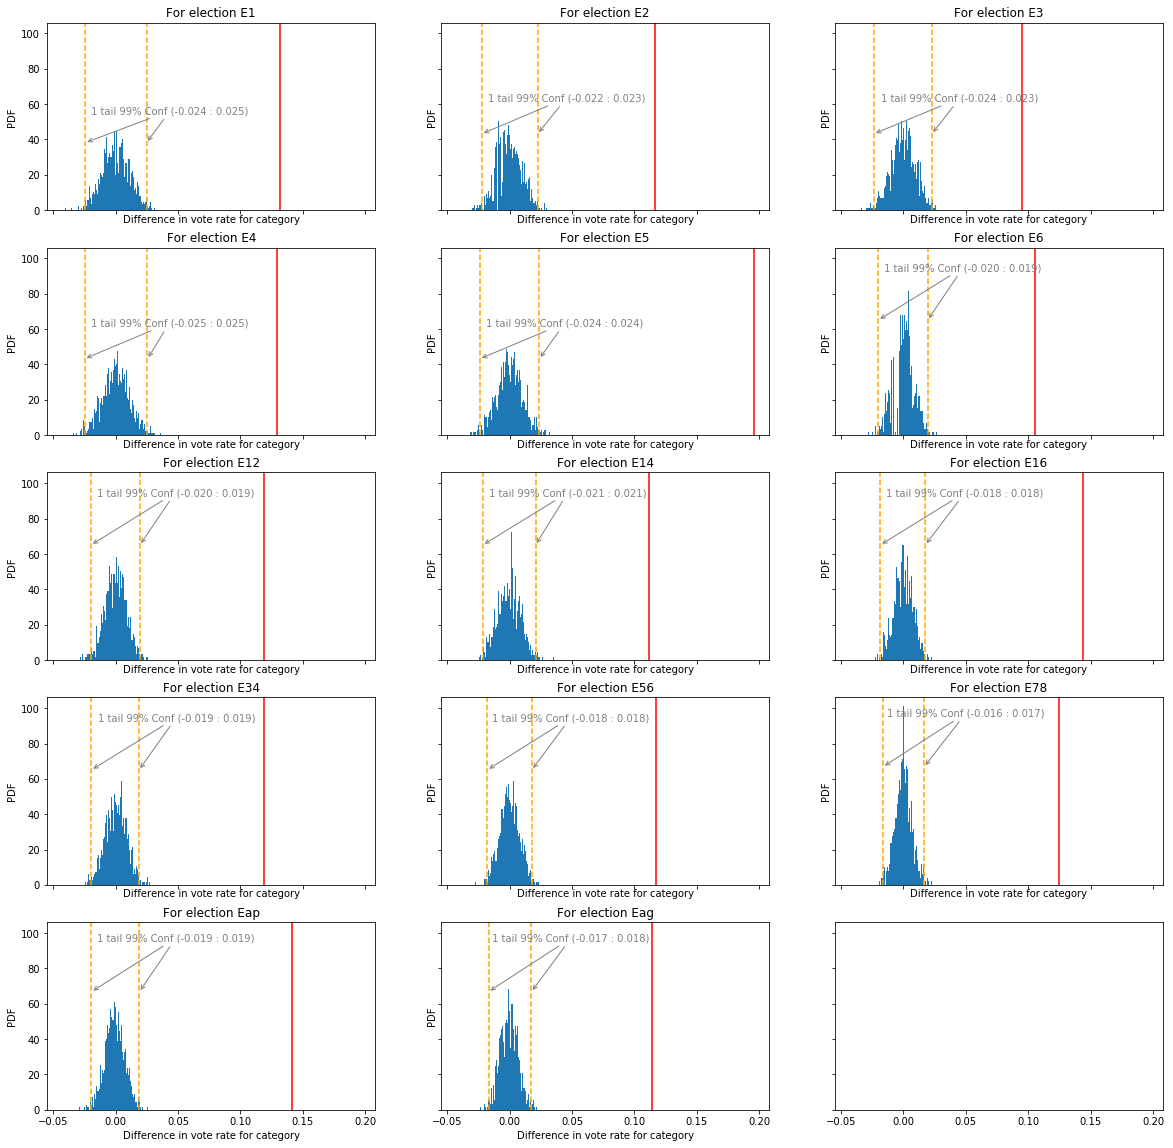

In [21]:
election_combs = ['E1','E2','E3','E4','E5','E6','E12','E14', 'E16', 'E34','E56','E78','Eap','Eag']
layout = [(i,j) for i in range(5) for j in range(3)]

fig, axes = plt.subplots(5,3,figsize=(20,20), sharex=True, sharey=True)

df = pd.DataFrame(columns=outcols)

for i,(e,loc) in enumerate(zip(election_combs,layout)):
    #display(Markdown('Processing **{}**...'.format(e)))
    vs, f = [e+'_nVotesPos',e+'_nVotes'],['HasParty']
    df_w = clean_df(voters.loc[:,vs + f], f, vs)
    (_, d1), (_, d0) = df_w.groupby(['HasParty'])
    s0,n0,r0,s1,n1,r1 = get_two_sample_ns(d0, d1)
    cz,cp = props.proportions_ztest([s0,s1], [n0,n1], alternative='larger')
    pp, emp_diff, axes[loc] = two_sample_perm_test_diff_frac_votes(d0,d1,axes[loc],'election '+e, tail=1)
    #display(Markdown('Empirical difference: **${:.2f}\%$**, Perm test estimated P-value: {}'.format(emp_diff*100,p)))
    df.loc[e,outcols] = [s0,n0,r0,s1,n1,r1,emp_diff*100,cz,cp,pp]

df.rename(columns ={'votes_s0':'v_hasP', 'elec_n0':'n_hasP', 'rate_r0':'rate_hasParty',
                       'votes_s1':'v_noP', 'elec_n1':'n_noP', 'rate_r1':'rate_noParty'}, inplace=True)    
df = df.rename(index = {'E1':'E1_060512','E2':'E2_110612','E3':'E3_060314',
                     'E4':'E4_110414','E5':'E5_060716','E6':'E6_110816',
                     'E12':'2012 (P&G)','E14':'2014 (P&G)', 'E16':'2016 (P&G)', 'E34':'2012 again','E56':'12,&14','E78':'12,14,&16',
                     'Eap':'All Primary','Eag':'All General'})
display(df)
plt.show()

## Grouping by PartyMain

In [22]:
# Gather data
e = 'E78'
vs, f = [e+'_nVotesPct', e+'_nVotesPos', e+'_nVotes'],['PartyMain']
df_w = clean_df(voters.loc[:,vs + f], f, vs)

df_g, df_s = df_w.loc[:,[e+'_nVotesPct']+f], df_w.loc[:,[e+'_nVotesPos',e+'_nVotes']+f]

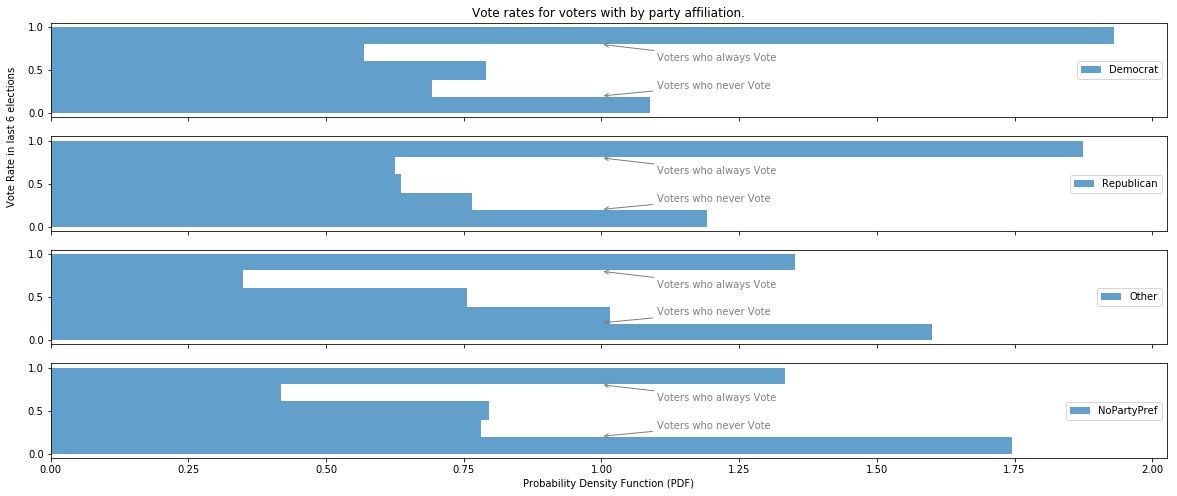

Number of Voters                              Voters as a %  \
                   Democrat Republican Other NoPartyPref  Democrat_pct   
Always                 2285        664   125         958          36.7   
Over Half               710        233    34         316          11.4   
Half                   1084        261    81         662          17.4   
Under Half              864        285    99         591          13.9   
Never                  1289        422   148        1254          20.7   
Totals                 6232       1865   487        3781         100.1   

                                                     
           Republican_pct Other_pct NoPartyPref_pct  
Always               35.6      25.7            25.3  
Over Half            12.5       7.0             8.4  
Half                 14.0      16.6            17.5  
Under Half           15.3      20.3            15.6  
Never                22.6      30.4            33.2  
Totals              100.0     100.0           100.0

In [23]:
# Summarize data
(k3, d3), (k2, d2), (k1, d1), (k0, d0) = df_g.groupby(['PartyMain'])
df_w = pd.DataFrame({k3:d3[vs[0]], k0:d0[vs[0]], k1:d1[vs[0]], k2:d2[vs[0]]})
title = 'Vote rates for voters with by party affiliation.'
df = show_vote_rate_and_summary(df_w, ['Democrat','Republican','Other','NoPartyPref'], title)

You can see clearly that having a party preference of one of the two main parties increases your likelihood of always voting. The affect is much less marked if you are a member of one of the minor parties, and having No Party Preference means you are most likely to be a never voter, 33% of NPP voters never vote.

Note the NPP number are slightly different to the earlier HasParty analysis as this data removed the 27 'UNK' rather than assumed they were NPP's.

### Is this a real effect?
I used the same two tests as with the has_party analysis, an automated 2 sample z test and a two sample permutation test.

I analyzed the data for all the elections combined, and calculated statistical significant of each of the 4 main party groups against each other. So testing the following and its combinations with different party REP, DEM, OTH, NPP:
- H0: The vote rate of people affiliated with the DEM matches that of those affiliated with the REP (the difference in vote proportion is 0)
- Ha: The vote rate of people affiliated with the DEM is lower or higher than that of those affiliated with the REP

Alpha = 0.01

I tested each of the 4 main party groups (DEM, REP, OTH, NPP) against each other a total of 6 tests.

,votes_s0,elec_n0,rate_r0,votes_s1,elec_n1,rate_r1,emp_diff,calc_z,calc_p,perm_p
All elections DEM:NPP,16858,30828,54.6841,7291,17609,41.405,13.2791,28.1159,6.26756e-174,0
All elections DEM:OTH,16858,30828,54.6841,937,2294,40.8457,13.8384,12.8243,1.19804e-37,0
All elections DEM:REP,16858,30828,54.6841,5582,10246,54.4798,0.204256,0.359786,0.719007,0.4123
All elections NPP:OTH,7291,17609,41.405,937,2294,40.8457,0.559279,0.511654,0.608893,0.3643
All elections NPP:REP,7291,17609,41.405,5582,10246,54.4798,-13.0748,-21.1061,6.99448e-99,0
All elections OTH:REP,937,2294,40.8457,5582,10246,54.4798,-13.6341,-11.8148,3.27502e-32,0


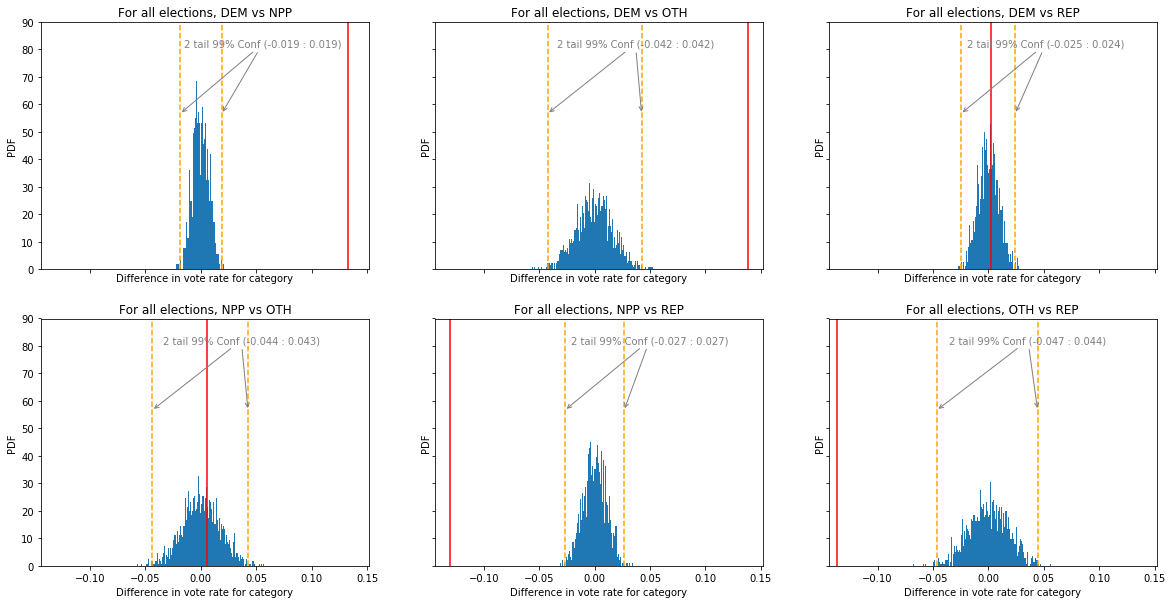

In [24]:
# Run Stats
g3, g2, g1, g0 = df_s.groupby(['PartyMain'])
party_combos = itertools.combinations([g3,g2,g1,g0], 2)
layout = [(i,j) for i in range(4) for j in range(3)]
fig, axes = plt.subplots(2,3,figsize=(20,10), sharex=True, sharey=True)

df = pd.DataFrame(columns=outcols)

for ((kx,dx),(ky,dy)),loc in zip(party_combos,layout):
    #display(Markdown('Processing **{} & {}**...'.format(kx, ky)))
    sx,nx,rx,sy,ny,ry = get_two_sample_ns(dx, dy)
    cz,cp = props.proportions_ztest([sx,sy], [nx,ny], alternative='two-sided')
    pp, emp_diff, axes[loc] = two_sample_perm_test_diff_frac_votes(dx,dy,axes[loc],
                                                                  'all elections, {} vs {}'.format(kx,ky), tail=2)   
    df.loc['All elections '+kx+':'+ky,outcols] = [sx,nx,rx,sy,ny,ry,emp_diff*100,cz,cp,pp]
    
display(df)
plt.show()

This is a two tail test so any p-value with a magnitude of $<0.05$ would require us to reject the null hypothesis. In this case although the two tests are providing slightly different p-value estimates they agree on which hypothesis we have to reject and which we fail to reject.

We fail to reject in the following cases:
- DEM vs REP - the vote rate of someone affiliated with the Republicans is not statistically different from the vote rate for someone affiliated with the Democrats.
- NPP vs OTH - the vote rate of someone affiliated with the No Party is not statistically different from the vote rate for someone affiliated with one of the small parties.

We reject the null hypothesis in all the other cases, Our data indicates that with 99% confidence the vote rate of someone belonging to one of the two main parties (REP or DEM) is Significantly higher than the vote rate of someone belonging to one of the minor parties or holding No Party Preference.

## Full Correlation Matrix of Household characteristics

In [25]:
#election_combos = ['E1','E2','E3','E4','E5','E6','E12','E14', 'E16', 'E34','E56','E78','Eap','Eag']
election_combos = ['E1','E2','E3','E4','E5','E6','E78','Eap','Eag']
v_combos = ['_nVotesPct', '_nVotesPctInHH']
vs = [j+i for i in v_combos for j in election_combos]
f = ['nVotersInHH','nPAVInHH','nAffInHH','nDEMInHH','nREPInHH','nNPPInHH',
     'mixedAfflsInHH','allAffInHH','uniformAffInHH']
df = clean_df(voters.loc[:,vs + f], f, vs)

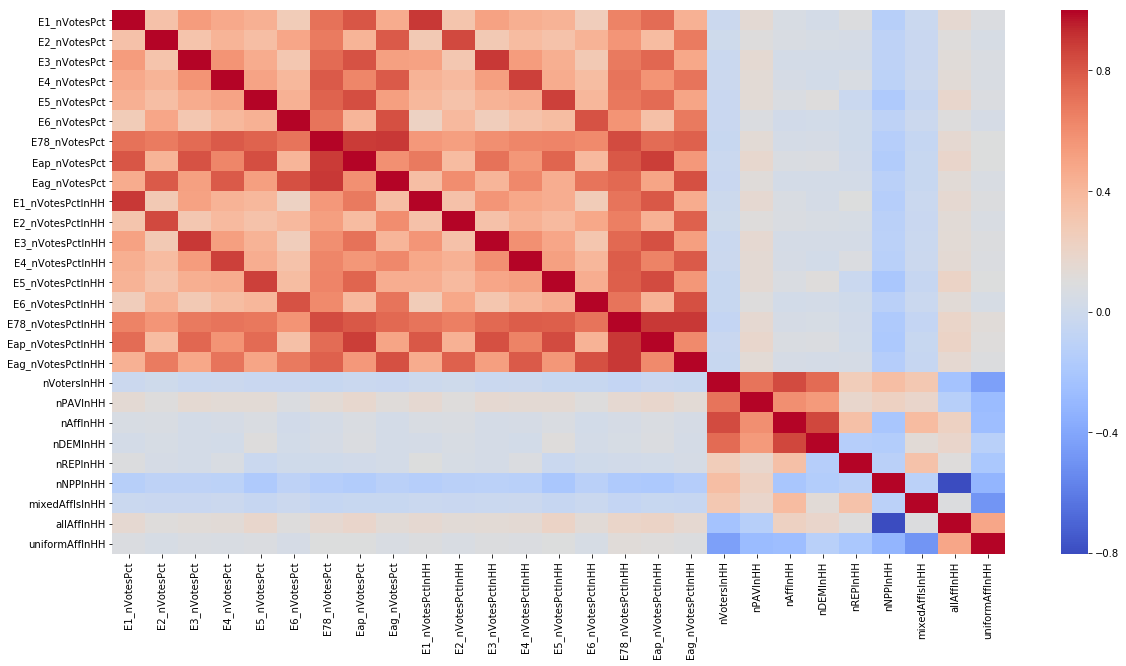

In [26]:
plt.rcParams["figure.figsize"] = (20,10)
# plot the heatmap
sns.heatmap(df.corr(), 
        xticklabels=df.corr().columns,
        yticklabels=df.corr().columns, cmap='coolwarm')
plt.show()

You can see a slight positive correlation with voting for Permanent Absentee Voters, and living in a HH where everyone is affiliated with a party. You can see slight negative correlations with the number of people with No Party Preference, and living in mixed Affiliated households. There is also a slight negative correlation with the over all number of voters in your household.

In [27]:
df.corr()

,E1_nVotesPct,E2_nVotesPct,E3_nVotesPct,E4_nVotesPct,E5_nVotesPct,E6_nVotesPct,E78_nVotesPct,Eap_nVotesPct,Eag_nVotesPct,E1_nVotesPctInHH,...,Eag_nVotesPctInHH,nVotersInHH,nPAVInHH,nAffInHH,nDEMInHH,nREPInHH,nNPPInHH,mixedAfflsInHH,allAffInHH,uniformAffInHH
E1_nVotesPct,1.000000,0.339831,0.537430,0.475543,0.437146,0.273931,0.705537,0.807519,0.462675,0.900745,...,0.430802,-0.018642,0.145686,0.060136,0.028491,0.086615,-0.132718,-0.022527,0.154937,0.083171
E2_nVotesPct,0.339831,1.000000,0.324868,0.420487,0.362968,0.490110,0.671296,0.420452,0.794646,0.294218,...,0.670164,0.006271,0.104241,0.064903,0.052513,0.045301,-0.097441,-0.029492,0.112031,0.052582
E3_nVotesPct,0.537430,0.324868,1.000000,0.572263,0.462117,0.305523,0.739326,0.818999,0.514796,0.509467,...,0.484132,-0.023008,0.152138,0.033656,0.034040,0.029072,-0.095469,-0.031895,0.124410,0.076788
E4_nVotesPct,0.475543,0.420487,0.572263,1.000000,0.501627,0.401027,0.788914,0.629508,0.794438,0.427238,...,0.702080,-0.016531,0.136145,0.045811,0.024275,0.064564,-0.104779,-0.019106,0.129214,0.067726
E5_nVotesPct,0.437146,0.362968,0.462117,0.501627,1.000000,0.429906,0.762721,0.830997,0.527523,0.395356,...,0.497190,-0.029513,0.137953,0.074088,0.103868,-0.021974,-0.171950,-0.042526,0.182333,0.081903
E6_nVotesPct,0.273931,0.490110,0.305523,0.401027,0.429906,1.000000,0.702193,0.409995,0.826465,0.219326,...,0.678729,-0.034651,0.083193,0.020217,0.021990,0.009777,-0.096907,-0.020513,0.104862,0.042555
E78_nVotesPct,0.705537,0.671296,0.739326,0.788914,0.762721,0.702193,1.000000,0.892297,0.897052,0.553405,...,0.767651,-0.037855,0.138059,0.040014,0.048880,0.010542,-0.136764,-0.050570,0.159256,0.092429
Eap_nVotesPct,0.807519,0.420452,0.818999,0.629508,0.830997,0.409995,0.892297,1.000000,0.587788,0.680690,...,0.551756,-0.023723,0.170999,0.074169,0.082073,0.019630,-0.162039,-0.036634,0.187250,0.092805
Eag_nVotesPct,0.462675,0.794646,0.514796,0.794438,0.527523,0.826465,0.897052,0.587788,1.000000,0.363621,...,0.829882,-0.029952,0.112866,0.034919,0.029974,0.031627,-0.114023,-0.037927,0.133081,0.069671
E1_nVotesPctInHH,0.900745,0.294218,0.509467,0.427238,0.395356,0.219326,0.553405,0.680690,0.363621,1.000000,...,0.462832,-0.013732,0.155020,0.066206,0.035415,0.094673,-0.140488,-0.027370,0.161121,0.089888


## Full Correlation Matrix of Voter characteristics

In [28]:
#election_combos = ['E1','E2','E3','E4','E5','E6','E12','E14', 'E16', 'E34','E56','E78','Eap','Eag']
election_combos = ['E1','E2','E3','E4','E5','E6','E78','Eap','Eag']
v_combos = ['_nVotesPct']
vs = [j+i for i in v_combos for j in election_combos]
f = ['Abbr','Precinct','BirthYear','OldestInHouseBirthYear','IsOldestInHouse',
     'havePhone','sameMailAddress','PAV','isApt','Zip','HasParty', 'isDEM','isREP','isNPP']
df = clean_df(voters.loc[:,vs + f], f, vs)
# converting PAV Y/N to True/False
df['PAV'] = df['PAV'].str.contains('Y')

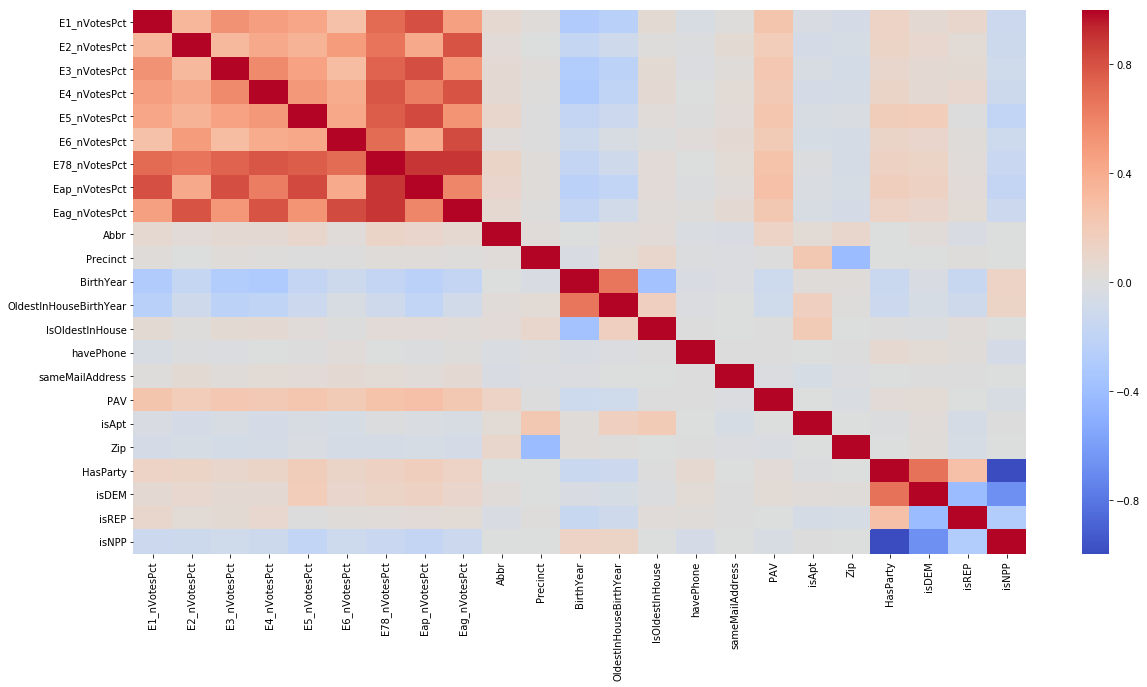

In [29]:
plt.rcParams["figure.figsize"] = (20,10)
# plot the heatmap
sns.heatmap(df.corr(), 
        xticklabels=df.corr().columns,
        yticklabels=df.corr().columns, cmap='coolwarm')
plt.show()

Correlations can be see with Permanent Absentee Ballots, being the oldest in your household and age (negative birthYear), also with having a party affiliation and negatively with being a No Party Preference.

In [30]:
df.corr()

,E1_nVotesPct,E2_nVotesPct,E3_nVotesPct,E4_nVotesPct,E5_nVotesPct,E6_nVotesPct,E78_nVotesPct,Eap_nVotesPct,Eag_nVotesPct,Abbr,...,IsOldestInHouse,havePhone,sameMailAddress,PAV,isApt,Zip,HasParty,isDEM,isREP,isNPP
E1_nVotesPct,1.000000,0.339831,0.537430,0.475543,0.437146,0.273931,0.705537,0.807519,0.462675,0.070468,...,0.051898,-0.041056,0.014139,0.246619,-0.034646,-0.060122,0.127421,0.061561,0.090061,-0.128936
E2_nVotesPct,0.339831,1.000000,0.324868,0.420487,0.362968,0.490110,0.671296,0.420452,0.794646,0.040450,...,0.013839,-0.005537,0.052014,0.182718,-0.066108,-0.048985,0.120025,0.087239,0.042514,-0.120706
E3_nVotesPct,0.537430,0.324868,1.000000,0.572263,0.462117,0.305523,0.739326,0.818999,0.514796,0.060521,...,0.054440,-0.019639,0.020852,0.235247,-0.041901,-0.070626,0.094674,0.063763,0.052849,-0.094969
E4_nVotesPct,0.475543,0.420487,0.572263,1.000000,0.501627,0.401027,0.788914,0.629508,0.794438,0.063047,...,0.060815,-0.002112,0.042002,0.219345,-0.062222,-0.057127,0.118015,0.062815,0.081539,-0.119068
E5_nVotesPct,0.437146,0.362968,0.462117,0.501627,1.000000,0.429906,0.762721,0.830997,0.527523,0.089464,...,0.029047,0.008718,0.040163,0.240104,-0.037945,-0.022910,0.180357,0.182250,0.004776,-0.180530
E6_nVotesPct,0.273931,0.490110,0.305523,0.401027,0.429906,1.000000,0.702193,0.409995,0.826465,0.029897,...,0.007641,0.030408,0.063795,0.201420,-0.045812,-0.056259,0.112009,0.097718,0.019526,-0.111828
E78_nVotesPct,0.705537,0.671296,0.739326,0.788914,0.762721,0.702193,1.000000,0.892297,0.897052,0.115448,...,0.035346,-0.000426,0.047737,0.264846,-0.012920,-0.054879,0.139722,0.124154,0.028617,-0.140250
Eap_nVotesPct,0.807519,0.420452,0.818999,0.629508,0.830997,0.409995,0.892297,1.000000,0.587788,0.096062,...,0.039859,-0.012103,0.032606,0.276962,-0.023013,-0.044664,0.169758,0.146912,0.040304,-0.170372
Eag_nVotesPct,0.462675,0.794646,0.514796,0.794438,0.527523,0.826465,0.897052,0.587788,1.000000,0.068278,...,0.029517,0.015136,0.061436,0.228092,-0.039533,-0.061724,0.127391,0.099217,0.043615,-0.127721
Abbr,0.070468,0.040450,0.060521,0.063047,0.089464,0.029897,0.115448,0.096062,0.068278,1.000000,...,0.037651,-0.028249,-0.035555,0.130060,0.046193,0.095783,0.000406,0.026616,-0.033653,-0.000326


## PAV voters

In [31]:
# Gather data
e = 'E78'
vs, f = [e+'_nVotesPct', e+'_nVotesPos', e+'_nVotes'],['PAV']
df_w = clean_df(voters.loc[:,vs + f], f, vs)

df_g, df_s = df_w.loc[:,[e+'_nVotesPct']+f], df_w.loc[:,[e+'_nVotesPos',e+'_nVotes']+f]

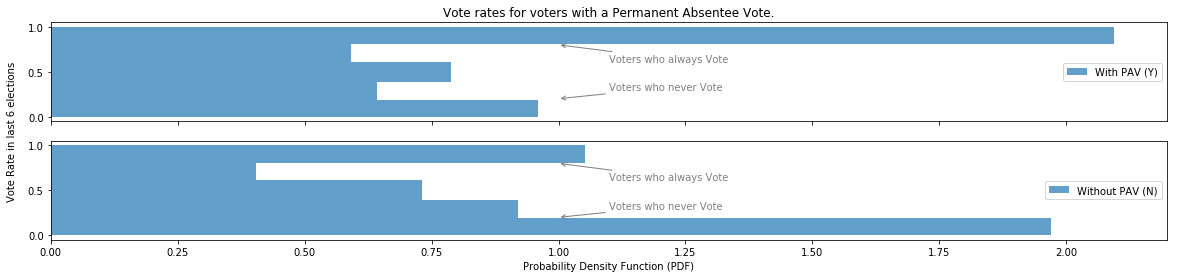

Number of Voters                    Voters as a %  \
               With PAV (Y) Without PAV (N) With PAV (Y)_pct   
Always                 3141             895             39.8   
Over Half               934             362             11.8   
Half                   1371             720             17.4   
Under Half             1014             825             12.8   
Never                  1439            1677             18.2   
Totals                 7899            4479            100.0   

                                
           Without PAV (N)_pct  
Always                    20.0  
Over Half                  8.1  
Half                      16.1  
Under Half                18.4  
Never                     37.4  
Totals                   100.0

In [32]:
# Summarize data
(k1, d1), (k0, d0) = df_g.groupby(['PAV'])
df_w = pd.DataFrame({k0:d0[vs[0]],k1:d1[vs[0]]})
title = 'Vote rates for voters with a Permanent Absentee Vote.'
df = show_vote_rate_and_summary(df_w, ['With PAV ('+k0+')','Without PAV ('+k1+')'], title)

,votes_s0,elec_n0,rate_r0,votes_s1,elec_n1,rate_r1,emp_diff,calc_z,calc_p,perm_p
All elections PAV N:Y,8261,22460,36.7809,22440,38570,58.1799,-21.399,-50.9905,0,0


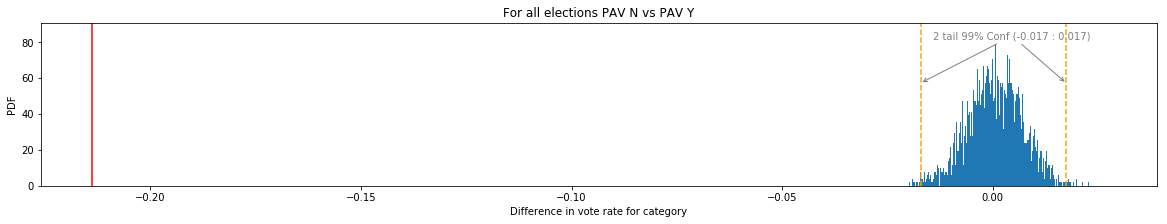

In [33]:
# Run Stats
(kx,dx),(ky,dy) = df_s.groupby(['PAV'])
fig, axes = plt.subplots(figsize=(20,3))

df = pd.DataFrame(columns=outcols)
sx,nx,rx,sy,ny,ry = get_two_sample_ns(dx, dy)
cz,cp = props.proportions_ztest([sx,sy], [nx,ny], alternative='two-sided')
pp, emp_diff, axes = two_sample_perm_test_diff_frac_votes(dx,dy,axes,
                                                         'all elections PAV {} vs PAV {}'.format(kx,ky), tail=2)   
df.loc['All elections PAV '+kx+':'+ky,outcols] = [sx,nx,rx,sy,ny,ry,emp_diff*100,cz,cp,pp]

display(df)
plt.show()

The low P value indicates we have to reject the null hypothesis and concludes with 99% confidence that having a permanent Absentee Ballot significantly increases the likelihood of your being in the always voter category. Our observations indicate ~20% greater chance of being an always voter.

## Gender

In [34]:
# Gather data
e = 'E78'
vs, f = [e+'_nVotesPct', e+'_nVotesPos', e+'_nVotes'],['Gender']
df_w = clean_df(voters.loc[:,vs + f], f, vs)

df_g, df_s = df_w.loc[:,[e+'_nVotesPct']+f], df_w.loc[:,[e+'_nVotesPos',e+'_nVotes']+f]

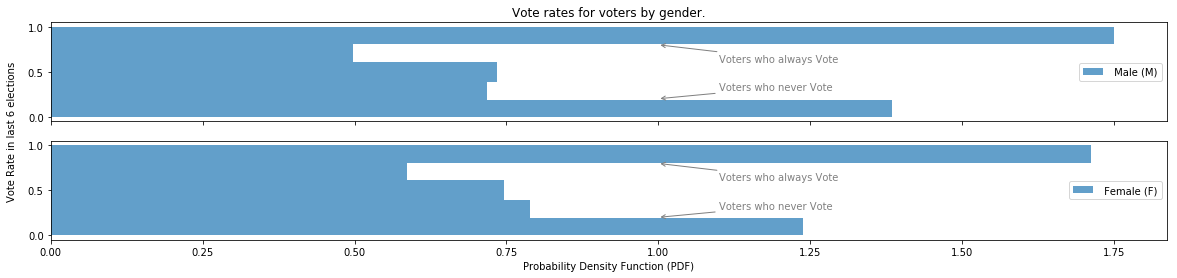

Number of Voters             Voters as a %                
                   Male (M)  Female (F)  Male (M)_pct  Female (F)_pct
Always                 1751        1838          33.2            32.5
Over Half               524         663           9.9            11.7
Half                    851         928          16.2            16.4
Under Half              757         892          14.4            15.8
Never                  1386        1330          26.3            23.5
Totals                 5269        5651         100.0            99.9

In [35]:
# Summarize data
(k2, d2),(k1, d1),(_, _) = df_g.groupby(['Gender'])
df_w = pd.DataFrame({k1:d1[vs[0]],k2:d2[vs[0]]})
title = 'Vote rates for voters by gender.'
df = show_vote_rate_and_summary(df_w, [' Male ('+k1+')',' Female ('+k2+')'], title)

,votes_s0,elec_n0,rate_r0,votes_s1,elec_n1,rate_r1,emp_diff,calc_z,calc_p,perm_p
All elections GenderF:M,14797,28760,51.4499,13243,26449,50.0699,1.37998,3.24006,0.00119507,0.0229


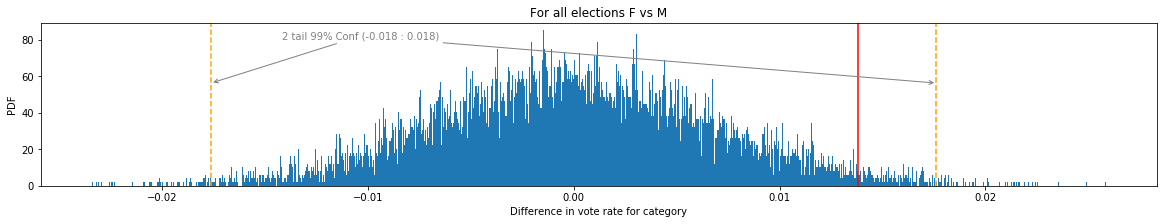

In [36]:
# Run Stats
(kx, dx),(ky, dy),(_, _) = df_s.groupby(['Gender'])
fig, axes = plt.subplots(figsize=(20,3))

df = pd.DataFrame(columns=outcols)
sx,nx,rx,sy,ny,ry = get_two_sample_ns(dx, dy)
cz,cp = props.proportions_ztest([sx,sy], [nx,ny], alternative='two-sided')
pp, emp_diff, axes = two_sample_perm_test_diff_frac_votes(dx,dy,axes,
                                                         'all elections {} vs {}'.format(kx,ky), tail=2)   
df.loc['All elections Gender'+kx+':'+ky, outcols] = [sx,nx,rx,sy,ny,ry,emp_diff*100,cz,cp,pp]
    
display(df)
plt.show()

Running our two Statistical Significance tests indicates that fail to reject the null hypothesis and can say with 99% confidence that the variation in male and female vote rate we see is likely due to chance. Note I'm putting more weight on the permutation test result as it is more appropriate given our sampling method. 

It is interesting to observe that on an individual level men are more likely to be a member of one of the extreme categories (ie always voting or never voting), women are more likely to sometimes cast their ballot.

## BirthState Region
Excluding Californians

In [37]:
# Gather data
e = 'E78'
vs, f = [e+'_nVotesPct', e+'_nVotesPos', e+'_nVotes'],['BirthPlaceState','BirthPlaceStateRegion']
df_w = clean_df(voters.loc[:,vs + f], f, vs)

# Removing Voters born in California
df_w.loc[df_w.BirthPlaceState == 'California', 'BirthPlaceStateRegion'] = np.NaN
df_w = df_w.drop('BirthPlaceState', axis=1)
f = ['BirthPlaceStateRegion']

df_g, df_s = df_w.loc[:,[e+'_nVotesPct']+f], df_w.loc[:,[e+'_nVotesPos',e+'_nVotes']+f]

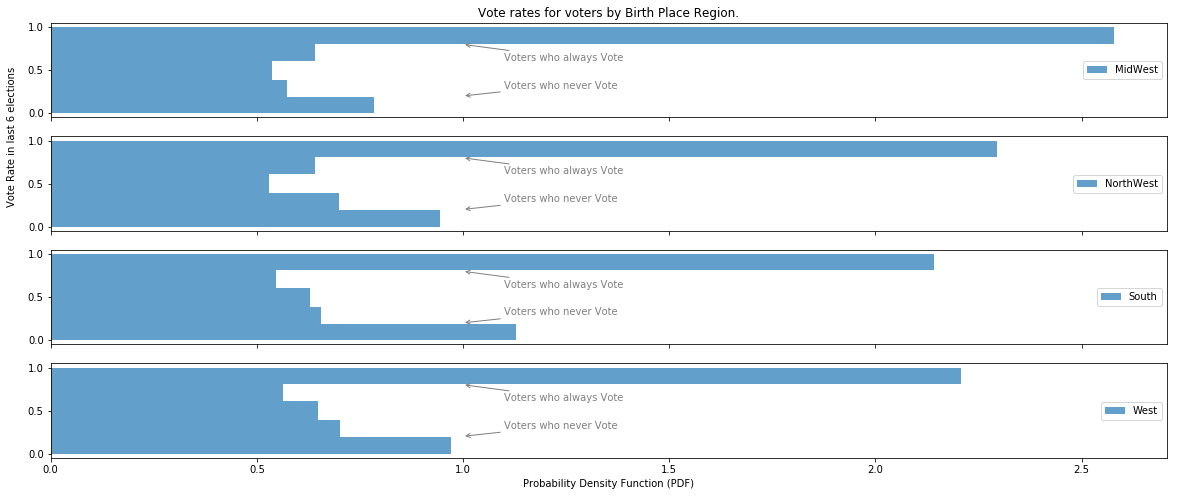

Number of Voters                      Voters as a %                \
                    MidWest NorthWest South West   MidWest_pct NorthWest_pct   
Always                  286       187   171  182          49.0          43.6   
Over Half                75        55    46   49          12.8          12.8   
Half                     69        50    58   62          11.8          11.7   
Under Half               67        60    55   61          11.5          14.0   
Never                    87        77    90   80          14.9          17.9   
Totals                  584       429   420  434         100.0         100.0   

                               
           South_pct West_pct  
Always          40.7     41.9  
Over Half       11.0     11.3  
Half            13.8     14.3  
Under Half      13.1     14.1  
Never           21.4     18.4  
Totals         100.0    100.0

In [38]:
# Summarize data
(k3, d3), (k2, d2), (k1, d1), (k0, d0) = df_g.groupby(['BirthPlaceStateRegion'])
df_w = pd.DataFrame({k3:d3[vs[0]], k2:d2[vs[0]], k1:d1[vs[0]], k0:d0[vs[0]]})
title = 'Vote rates for voters by Birth Place Region.'
df = show_vote_rate_and_summary(df_w, [k3,k2,k1,k0], title)

,votes_s0,elec_n0,rate_r0,votes_s1,elec_n1,rate_r1,emp_diff,calc_z,calc_p,perm_p
All elections: MidWest:NorthWest,2054,3163,64.9383,1377,2265,60.7947,4.14365,3.12167,0.00179828,0.0284
All elections: MidWest:South,2054,3163,64.9383,1317,2285,57.6368,7.30159,5.47559,4.36055e-08,0.0009
All elections: MidWest:West,2054,3163,64.9383,1386,2317,59.8187,5.11962,3.87299,0.000107509,0.0105
All elections: NorthWest:South,1377,2265,60.7947,1317,2285,57.6368,3.15794,2.1672,0.0302196,0.0999
All elections: NorthWest:West,1377,2265,60.7947,1386,2317,59.8187,0.975971,0.675079,0.499625,0.3501
All elections: South:West,1317,2285,57.6368,1386,2317,59.8187,-2.18197,-1.50329,0.132764,0.187


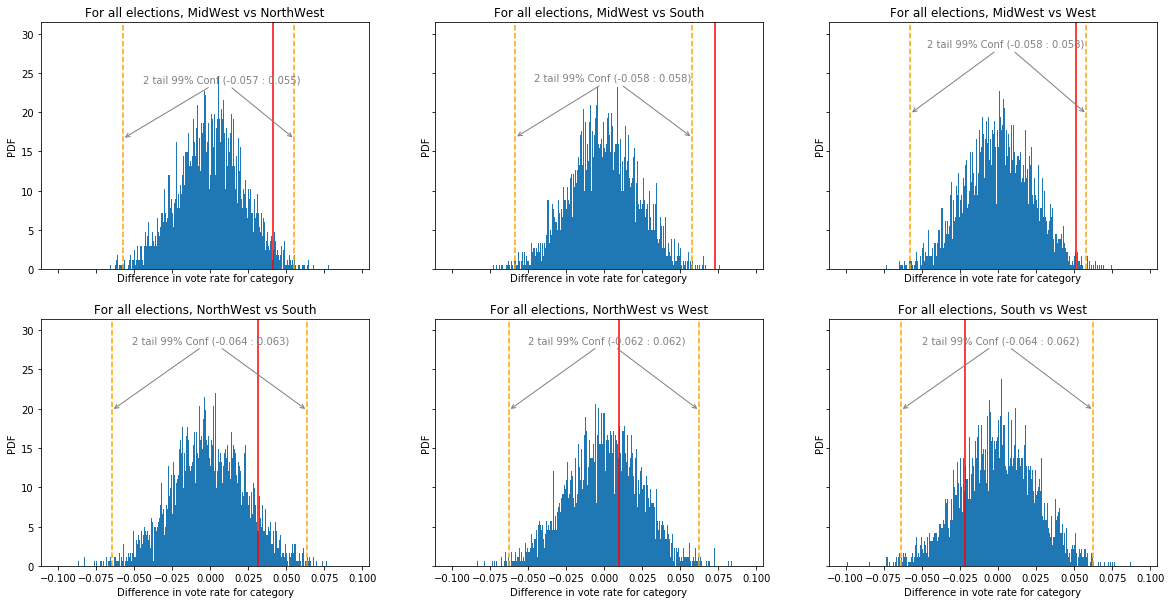

In [39]:
# Run Stats
g3, g2, g1, g0  = df_s.groupby(['BirthPlaceStateRegion'])
region_combos = list(itertools.combinations([g3, g2, g1, g0], 2))
layout = [(i,j) for i in range(2) for j in range(3)]

fig, axes = plt.subplots(2,3,figsize=(20,10), sharex=True, sharey=True)

df = pd.DataFrame(columns=outcols)
for ((kx,dx),(ky,dy)),loc in zip(region_combos,layout):
    #display(Markdown('Processing **{} & {}**...'.format(kx, ky)))
    sx,nx,rx,sy,ny,ry = get_two_sample_ns(dx, dy)
    cz,cp = props.proportions_ztest([sx,sy], [nx,ny], alternative='two-sided')
    pp, emp_diff, axes[loc] = two_sample_perm_test_diff_frac_votes(dx,dy,axes[loc],
                                                                  'all elections, {} vs {}'.format(kx,ky), tail=2)   
    df.loc['All elections: '+kx+':'+ky, outcols] = [sx,nx,rx,sy,ny,ry,emp_diff*100,cz,cp,pp]
    
display(df)
plt.show()

People born in the MidWest states tend to vote more often than those born elsewhere in the USA out of CA, grouped by birth region.
The statistical analysis causes us to reject the null hypothesis (that voters born in these regions have the same vote rate) in just one case although it came close in a few others:
- Voters born in the MidWest are more likely to vote than those born in the South (obs $\approx7\%$)

We fail to reject the null hypothesis when comparing vote rates for all other combinations of regions - the variations in vote rate we see in our data is 99% confident to be due to chance.

## BirthCountry

In [40]:
# Gather data
e = 'E78'
vs, f = [e+'_nVotesPct', e+'_nVotesPos', e+'_nVotes'],['BirthPlaceCountryRegion']
df_w = clean_df(voters.loc[:,vs + f], f, vs)
display(df_w.BirthPlaceCountryRegion.value_counts())

# removing Oceania and Africa as sample size is too small
df_w['BirthPlaceCountryRegion'].replace('Africa', np.NaN, inplace=True)
df_w['BirthPlaceCountryRegion'].replace('Oceania', np.NaN, inplace=True)
df_w['BirthPlaceCountryRegion'].replace('USA', 'A_USA', inplace=True)

df_g, df_s = df_w.loc[:,[e+'_nVotesPct']+f], df_w.loc[:,[e+'_nVotesPos',e+'_nVotes']+f]

USA         7074
Asia        3915
Americas     551
Europe       291
Africa        88
Oceania       59
Name: BirthPlaceCountryRegion, dtype: int64

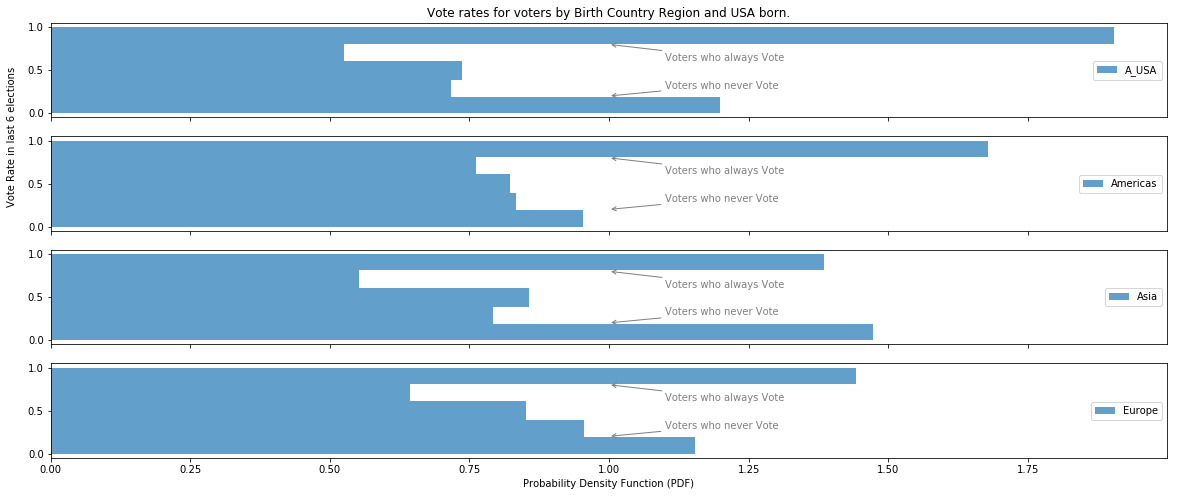

Number of Voters                       Voters as a %               \
                      A_USA Americas  Asia Europe     A_USA_pct Americas_pct   
Always                 2438       88   951    145          36.2         31.9   
Over Half               708       42   399     68          10.5         15.2   
Half                   1092       50   681     99          16.2         18.1   
Under Half              967       46   573    101          14.3         16.7   
Never                  1536       50  1011    116          22.8         18.1   
Totals                 6741      276  3615    529         100.0        100.0   

                                
           Asia_pct Europe_pct  
Always         26.3       27.4  
Over Half      11.0       12.9  
Half           18.8       18.7  
Under Half     15.9       19.1  
Never          28.0       21.9  
Totals        100.0      100.0

In [41]:
# Summarize data
(k3, d3), (k2, d2), (k1, d1), (k0, d0) = df_g.groupby(['BirthPlaceCountryRegion'])
df_w = pd.DataFrame({k3:d3[vs[0]], k0:d0[vs[0]], k1:d1[vs[0]], k2:d2[vs[0]]})
title = 'Vote rates for voters by Birth Country Region and USA born.'
df = show_vote_rate_and_summary(df_w, [k3,k2,k1,k0], title)

,votes_s0,elec_n0,rate_r0,votes_s1,elec_n1,rate_r1,emp_diff,calc_z,calc_p,perm_p
All elections: A_USA:Americas,18449,34199,53.946,1349,2730,49.4139,4.5321,4.56951,4.88869e-06,0.0025
All elections: A_USA:Asia,18449,34199,53.946,7877,17586,44.7913,9.15471,19.7344,1.09255e-86,0
All elections: A_USA:Europe,18449,34199,53.946,794,1483,53.5401,0.4059,0.307006,0.758839,0.4286
All elections: Americas:Asia,1349,2730,49.4139,7877,17586,44.7913,4.62261,4.51335,6.38131e-06,0.002
All elections: Americas:Europe,1349,2730,49.4139,794,1483,53.5401,-4.1262,-2.5586,0.0105096,0.0489
All elections: Asia:Europe,7877,17586,44.7913,794,1483,53.5401,-8.74881,-6.49767,8.15742e-11,0


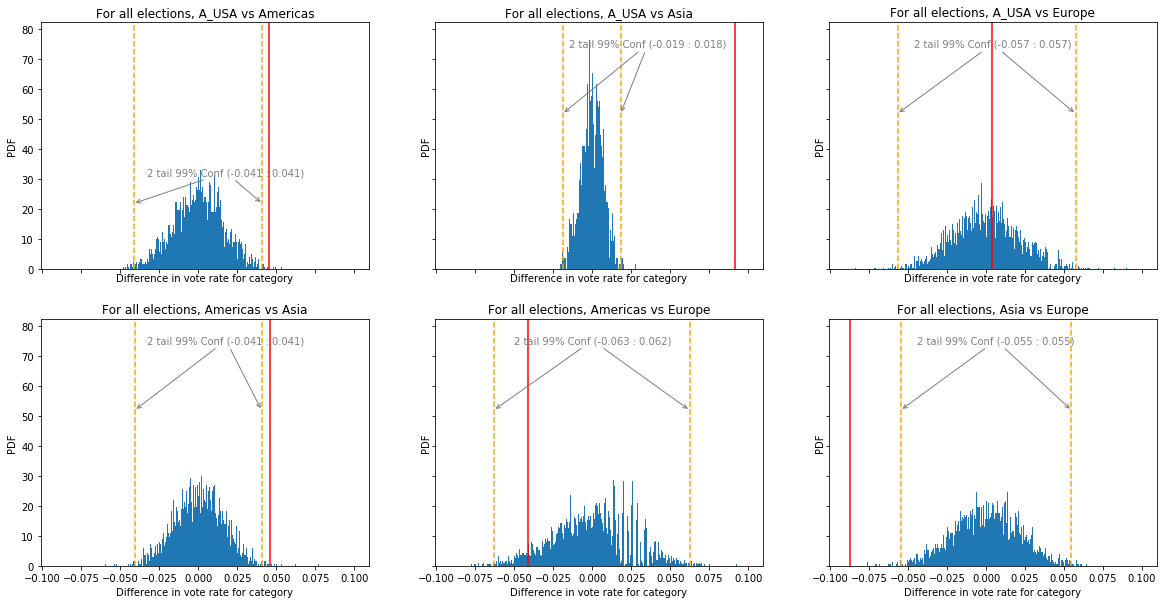

In [42]:
# Run Stats
g3, g2, g1, g0  = df_s.groupby(['BirthPlaceCountryRegion'])
region_combos = list(itertools.combinations([g3, g2, g1, g0], 2))
layout = [(i,j) for i in range(2) for j in range(3)]

fig, axes = plt.subplots(2,3,figsize=(20,10), sharex=True, sharey=True)

df = pd.DataFrame(columns=outcols)
for ((kx,dx),(ky,dy)),loc in zip(region_combos,layout):
    #display(Markdown('Processing **{} & {}**...'.format(kx, ky)))
    sx,nx,rx,sy,ny,ry = get_two_sample_ns(dx, dy)
    cz,cp = props.proportions_ztest([sx,sy], [nx,ny], alternative='two-sided')
    pp, emp_diff, axes[loc] = two_sample_perm_test_diff_frac_votes(dx,dy,axes[loc],
                                                                  'all elections, {} vs {}'.format(kx,ky), tail=2)   
    df.loc['All elections: '+kx+':'+ky, outcols] = [sx,nx,rx,sy,ny,ry,emp_diff*100,cz,cp,pp]
    
display(df)
plt.show()

The difference if vote rate based on the world region a voter was born in was statistically significant in 4 of our 6 comparison pairs:
- voters born in the USA are more likely to vote than those born in Asia (obs: $\approx9.2\%$) SS 99%
- voters born in Europe are more likely to vote than those born in Asia (obs: $\approx6.5\%$) SS 99%
- voters born in the USA are more likely to vote than those born elsewhere in the Americas (obs: $\approx4.5\%$) just SS 99%
- voters born elsewhere in the Americas are more likely to vote than those born in Asia (obs: $\approx4.6\%$) just SS 99%


We fail to reject the null hypothesis when comparing vote rate of people born in the USA to those born in Europe and when comparing vote rate for people born elsewhere in the Americas with to those born in Europe, our observed difference in vote rate is likely due to chance. The sample sizes were small in some of these cases and the results  only just statistically significance so you may not wish to take action on these results.

Voters born in Asia are more likely to end up in the never vote category. 
USA born voters are more likely to be in the Always vote category.

## CityArea

In [43]:
# Gather data
e = 'E78'
vs, f = [e+'_nVotesPct', e+'_nVotesPos', e+'_nVotes'],['CityArea']
df_w = clean_df(voters.loc[:,vs + f], f, vs)

print('Removing {} cityarea as our data only has {} voters in that area'.format(
df_w.CityArea.value_counts().index[-1],df_w.CityArea.value_counts()[-1]))
df_w['CityArea'].replace('Niles', np.NaN, inplace=True)

df_g, df_s = df_w.loc[:,[e+'_nVotesPct']+f], df_w.loc[:,[e+'_nVotesPos',e+'_nVotes']+f]

Removing Niles cityarea as our data only has 3 voters in that area


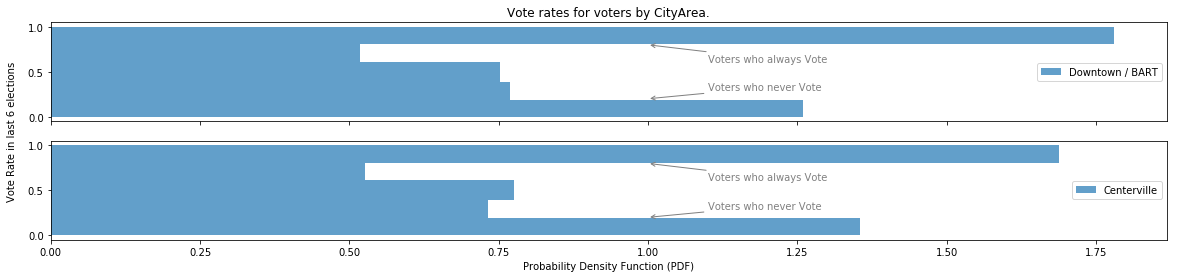

Number of Voters                   Voters as a %                
            Downtown / BART Centerville Downtown / BART_pct Centerville_pct
Always                 1272        2762                33.8            32.1
Over Half               390         906                10.4            10.5
Half                    622        1468                16.5            17.0
Under Half              579        1260                15.4            14.6
Never                   900        2216                23.9            25.7
Totals                 3763        8612               100.0            99.9

In [44]:
# Summarize data
(k1, d1),(k0, d0) = df_g.groupby(['CityArea'])
df_w = pd.DataFrame({k0:d0[vs[0]],k1:d1[vs[0]]})
title = 'Vote rates for voters by CityArea.'
df = show_vote_rate_and_summary(df_w, [k0,k1], title)

,votes_s0,elec_n0,rate_r0,votes_s1,elec_n1,rate_r1,emp_diff,calc_z,calc_p,perm_p
All elections: Centerville:Downtown / BART,21284,42624,49.9343,9403,18388,51.1366,-1.2023,-2.72545,0.00642145,0.0449


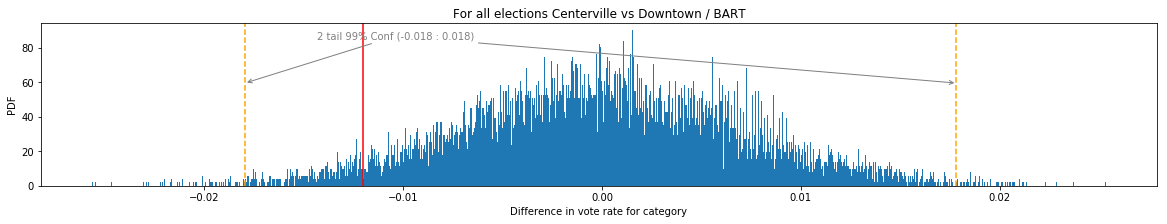

In [45]:
# Run Stats
(kx, dx),(ky, dy) = df_s.groupby(['CityArea'])
fig, axes = plt.subplots(figsize=(20,3))

df = pd.DataFrame(columns=outcols)
sx,nx,rx,sy,ny,ry = get_two_sample_ns(dx, dy)
cz,cp = props.proportions_ztest([sx,sy], [nx,ny], alternative='two-sided')
pp, emp_diff, axes = two_sample_perm_test_diff_frac_votes(dx,dy,axes,
                                                         'all elections {} vs {}'.format(kx,ky), tail=2)   
df.loc['All elections: '+kx+':'+ky, outcols] = [sx,nx,rx,sy,ny,ry,emp_diff*100,cz,cp,pp]
    
display(df)
plt.show()

Voters in Downtown/BART are a little more likely to vote than those in Centerville this affect carries over to them also being more likely to be in the always vote category and less like to be in the never vote category. However this affect is small observed at $\approx 1.2\%$ and is not statistically significant at 99% confidence its could be caused by chance.

## Living in an Apartment

In [46]:
# Gather data
e = 'E78'
vs, f = [e+'_nVotesPct', e+'_nVotesPos', e+'_nVotes'],['isApt']
df_w = clean_df(voters.loc[:,vs + f], f, vs)

df_g, df_s = df_w.loc[:,[e+'_nVotesPct']+f], df_w.loc[:,[e+'_nVotesPos',e+'_nVotes']+f]

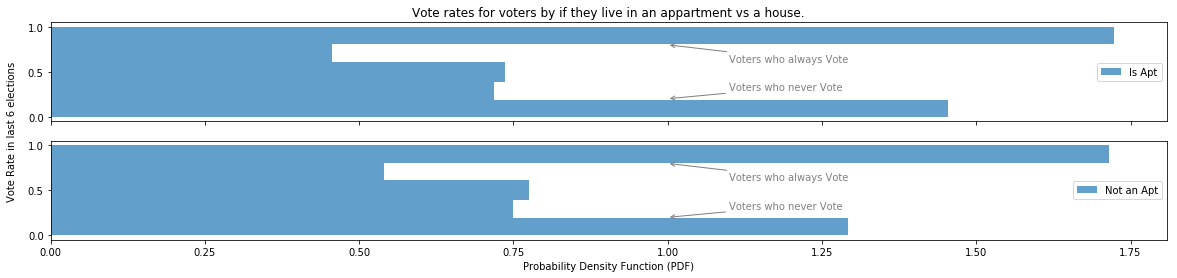

Number of Voters            Voters as a %               
                     Is Apt Not an Apt    Is Apt_pct Not an Apt_pct
Always                  809       3227          32.7           32.6
Over Half               225       1071           9.1           10.8
Half                    400       1691          16.2           17.1
Under Half              355       1484          14.4           15.0
Never                   683       2433          27.6           24.6
Totals                 2472       9906         100.0          100.1

In [47]:
# Summarize data
(k1, d1),(k0, d0) = df_g.groupby(['isApt'])
df_w = pd.DataFrame({k0:d0[vs[0]],k1:d1[vs[0]]})
title = 'Vote rates for voters by if they live in an appartment vs a house.'
df = show_vote_rate_and_summary(df_w, ['Is Apt','Not an Apt'], title)

,votes_s0,elec_n0,rate_r0,votes_s1,elec_n1,rate_r1,emp_diff,calc_z,calc_p,perm_p
All elections: Not an Apt:Is Apt,25635,50085,51.183,5066,10945,46.286,4.89701,9.28238,1.65732e-20,0


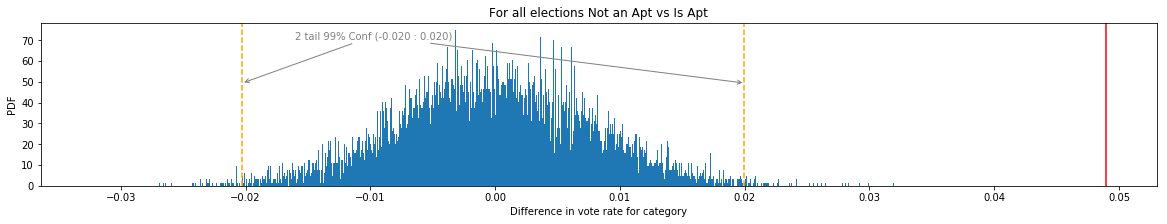

In [48]:
# Run Stats
(kx, dx),(ky, dy) = df_s.groupby(['isApt'])
fig, axes = plt.subplots(figsize=(20,3))
kx = 'Is Apt' if kx else 'Not an Apt'
ky = 'Is Apt' if kx else 'Not an Apt'

df = pd.DataFrame(columns=outcols)
sx,nx,rx,sy,ny,ry = get_two_sample_ns(dx, dy)
cz,cp = props.proportions_ztest([sx,sy], [nx,ny], alternative='two-sided')
pp, emp_diff, axes = two_sample_perm_test_diff_frac_votes(dx,dy,axes,
                                                         'all elections {} vs {}'.format(kx,ky), tail=2)   
df.loc['All elections: '+kx+':'+ky, outcols] = [sx,nx,rx,sy,ny,ry,emp_diff*100,cz,cp,pp]
    
display(df)
plt.show()

Voters who live in apartments are less likely to vote than voters who's address does not include an apartment number (obs: $\approx4.9\%$). This is a statistically significant result at 99% confidence.  

It is interesting to notice that voters living in Apartments seem a little more likely to be in the never voter category although are members of the always vote category about as frequently as other voters.

## Exploring how MailCountry is related to voting behavior

In [49]:
# Gather data
e = 'E78'
vs, f = [e+'_nVotesPct', e+'_nVotesPos', e+'_nVotes'],['MailCountry']
df_w = clean_df(voters.loc[:,vs + f], f, vs)

for_other=['GERMANY', 'JAPAN', 'THAILAND', 'ISRAEL', 'PHILIPPINES', 'CHINA', 'MYANMAR',
           'HONG KONG','TAIWAN', 'AUSTRALIA', 'SERBIA', 'SINGAPORE', 'SPAIN','GHANA', 
           'COSTA RICA', 'AUSTRIA', 'CHILE', 'LEBANON','GREECE', 'UNITED KINGDOM', 'MEXICO',
           'NEW ZEALAND','PAKISTAN', 'PERU', 'SWITZERLAND', 'ARGENTINA']
df_w['MC_Main'] = df_w.loc[df_w.MailCountry.notnull(),'MailCountry'].astype(str)
df_w.loc[df_w.MC_Main.isin(for_other) == True,['MC_Main']] = 'ZTHER'
df_w = df_w.drop('MailCountry', axis=1)

f = ['MC_Main']

df_g, df_s = df_w.loc[:,[e+'_nVotesPct']+f], df_w.loc[:,[e+'_nVotesPos',e+'_nVotes']+f]

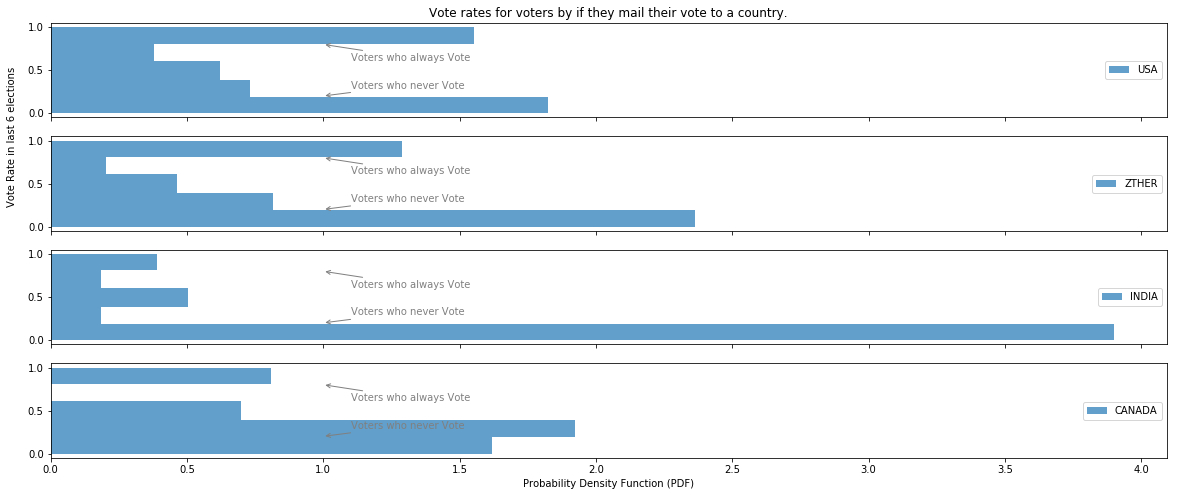

Number of Voters                    Voters as a %            \
                        USA ZTHER INDIA CANADA       USA_pct ZTHER_pct   
Always                   97    12     2      2          29.5      24.5   
Over Half                25     2     1      0           7.6       4.1   
Half                     45     5     3      2          13.7      10.2   
Under Half               48     8     1      5          14.6      16.3   
Never                   114    22    20      4          34.7      44.9   
Totals                  329    49    27     13         100.1     100.0   

                                 
           INDIA_pct CANADA_pct  
Always           7.4       15.4  
Over Half        3.7        0.0  
Half            11.1       15.4  
Under Half       3.7       38.5  
Never           74.1       30.8  
Totals         100.0      100.1

In [50]:
# Summarize data
(k3, d3), (k2, d2), (k1, d1), (k0, d0) = df_g.groupby(['MC_Main'])
df_w = pd.DataFrame({k1:d1[vs[0]],k0:d0[vs[0]],k2:d2[vs[0]],k3:d3[vs[0]]})
title = 'Vote rates for voters by if they mail their vote to a country.'
df = show_vote_rate_and_summary(df_w, [k1,k0,k2,k3], title)

,votes_s0,elec_n0,rate_r0,votes_s1,elec_n1,rate_r1,emp_diff,calc_z,calc_p,perm_p
All elections: CANADA:INDIA,21,60,35,28,138,20.2899,14.7101,2.20431,0.0275022,0.0697
All elections: CANADA:USA,21,60,35,662,1524,43.4383,-8.43832,-1.29458,0.195465,0.2271
All elections: CANADA:ZTHER,21,60,35,77,218,35.3211,-0.321101,-0.0461019,0.963229,0.4912
All elections: INDIA:USA,28,138,20.2899,662,1524,43.4383,-23.1485,-5.2846,1.2598e-07,0.0004
All elections: INDIA:ZTHER,28,138,20.2899,77,218,35.3211,-15.0312,-3.0301,0.00244477,0.0214
All elections: USA:ZTHER,662,1524,43.4383,77,218,35.3211,8.11722,2.26819,0.0233176,0.0841


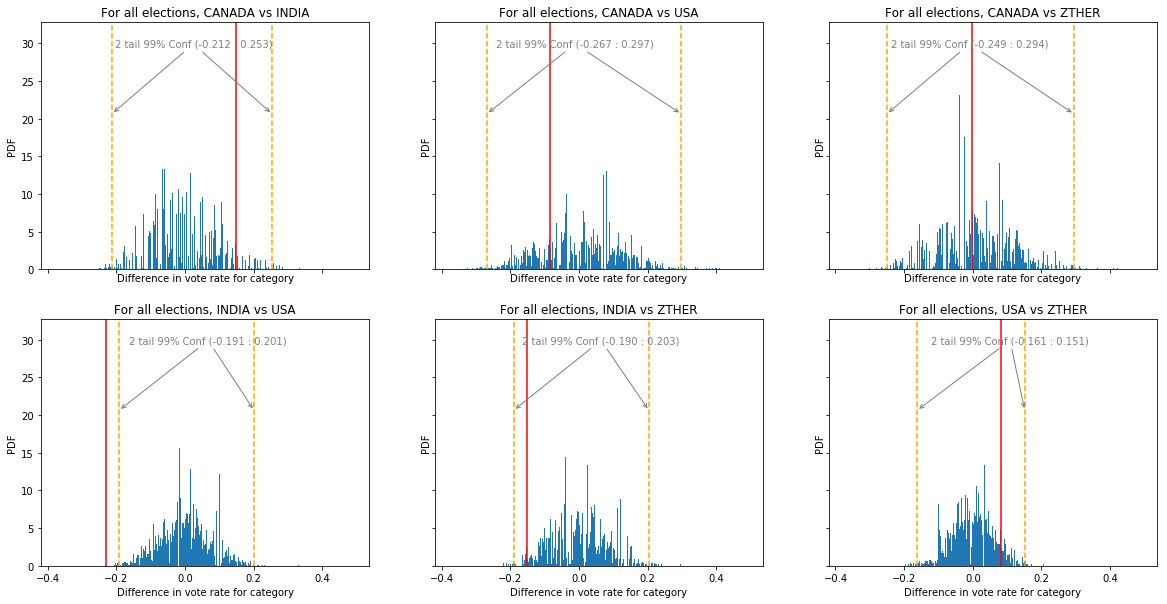

In [51]:
# Run Stats
g3, g2, g1, g0  = df_s.groupby(['MC_Main'])
region_combos = list(itertools.combinations([g3, g2, g1, g0], 2))
layout = [(i,j) for i in range(2) for j in range(3)]

fig, axes = plt.subplots(2,3,figsize=(20,10), sharex=True, sharey=True)

df = pd.DataFrame(columns=outcols)
for ((kx,dx),(ky,dy)),loc in zip(region_combos,layout):
    #display(Markdown('Processing **{} & {}**...'.format(kx, ky)))
    sx,nx,rx,sy,ny,ry = get_two_sample_ns(dx, dy)
    cz,cp = props.proportions_ztest([sx,sy], [nx,ny], alternative='two-sided')
    pp, emp_diff, axes[loc] = two_sample_perm_test_diff_frac_votes(dx,dy,axes[loc],
                                                                  'all elections, {} vs {}'.format(kx,ky), tail=2)   
    df.loc['All elections: '+kx+':'+ky, outcols] = [sx,nx,rx,sy,ny,ry,emp_diff*100,cz,cp,pp]
    
display(df)
plt.show()

Voters with mailing address' outside the USA ie are actually voting from overseas, are more likely to end up in the never vote category. Particularly if your mailing address is in India you have between a $\approx70\%$ chance of being a never voter!

That said there was little statistical significance in these findings as the sample sizes are so low. Only in one pairs of tests did we meet the 99% confidence level to reject the null hypothesis and say that voters with a mailing country of India are less likely to vote than those with a mail country of USA.

## Exploring how voter's household make up reflects in voting behavior
First looking at is all Voters in the Household are affiliated with a party:

In [52]:
e = 'E78'
vs, f = [e+'_nVotesPct', e+'_nVotesPos', e+'_nVotes'],['allAffInHH']
df_w = clean_df(voters.loc[:,vs + f], f, vs)

df_g, df_s = df_w.loc[:,[e+'_nVotesPct']+f], df_w.loc[:,[e+'_nVotesPos',e+'_nVotes']+f]

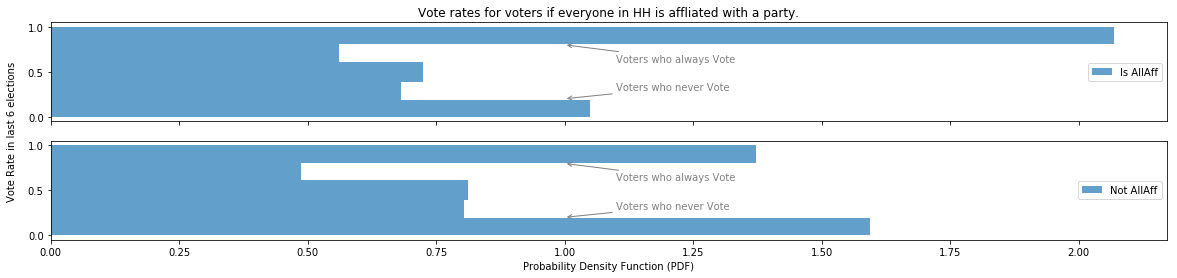

Number of Voters            Voters as a %               
                  Is AllAff Not AllAff Is AllAff_pct Not AllAff_pct
Always                 2403       1633          39.3           26.1
Over Half               687        609          11.2            9.7
Half                    974       1117          15.9           17.8
Under Half              833       1006          13.6           16.1
Never                  1220       1896          19.9           30.3
Totals                 6117       6261          99.9          100.0

In [53]:
# Summarize data
(k1, d1),(k0, d0) = df_g.groupby(['allAffInHH'])
df_w = pd.DataFrame({k0:d0[vs[0]],k1:d1[vs[0]]})
title = 'Vote rates for voters if everyone in HH is affliated with a party.'
df = show_vote_rate_and_summary(df_w, ['Is AllAff','Not AllAff'], title)

,votes_s0,elec_n0,rate_r0,votes_s1,elec_n1,rate_r1,emp_diff,calc_z,calc_p,perm_p
All elections: Not all aff in HH:All aff in HH,13289,30122,44.1173,17412,30908,56.3349,-12.2177,-30.1809,4.21846e-200,0


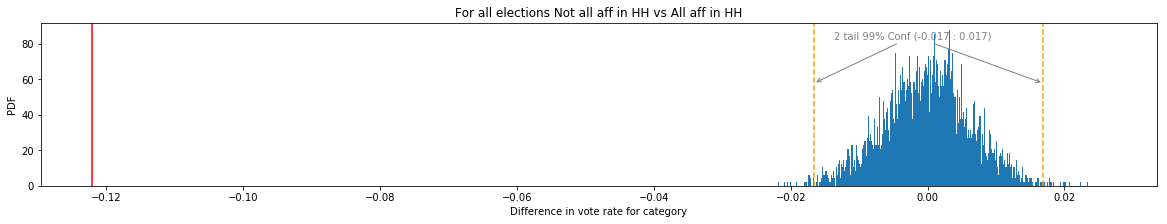

In [54]:
# Run Stats
(kx, dx),(ky, dy) = df_s.groupby(['allAffInHH'])
fig, axes = plt.subplots(figsize=(20,3))
kx = 'All aff in HH' if kx else 'Not all aff in HH'
ky = 'All aff in HH' if kx else 'Not all aff in HH'

df = pd.DataFrame(columns=outcols)
sx,nx,rx,sy,ny,ry = get_two_sample_ns(dx, dy)
cz,cp = props.proportions_ztest([sx,sy], [nx,ny], alternative='two-sided')
pp, emp_diff, axes = two_sample_perm_test_diff_frac_votes(dx,dy,axes,
                                                         'all elections {} vs {}'.format(kx,ky), tail=2)   
df.loc['All elections: '+kx+':'+ky, outcols] = [sx,nx,rx,sy,ny,ry,emp_diff*100,cz,cp,pp]
    
display(df)
plt.show()

If everyone in your house hold is affiliated with a political party you are $12\%$ more likely to vote than if you don't live in such a household. This result was statistically significant at 99% confidence.

Then looking at if the voters who live in a house with more than one voter and the household voters are affiliated with more than one party between them.

In [55]:
# Gather data
e = 'E78'
vs, f = [e+'_nVotesPct', e+'_nVotesPos', e+'_nVotes'],['mixedAfflsInHH','nVotersInHH']
df_w = clean_df(voters.loc[:,vs + f], f, vs)
#removing housholds with less than one voter 
df_w = df_w.loc[df_w.nVotersInHH>1]
df_g, df_s = df_w.loc[:,[e+'_nVotesPct']+f], df_w.loc[:,[e+'_nVotesPos',e+'_nVotes']+f]

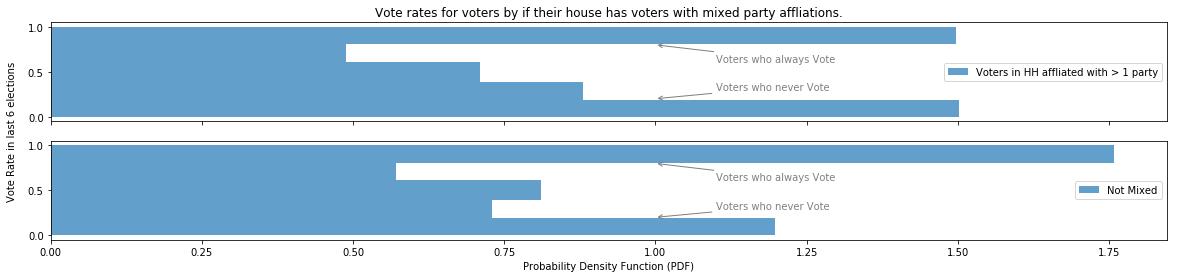

Number of Voters            \
           Voters in HH affliated with > 1 party Not Mixed   
Always                                       585      2534   
Over Half                                    201       867   
Half                                         321      1353   
Under Half                                   362      1108   
Never                                        587      1726   
Totals                                      2056      7588   

                                       Voters as a %                
           Voters in HH affliated with > 1 party_pct Not Mixed_pct  
Always                                          28.5          33.4  
Over Half                                        9.8          11.4  
Half                                            15.6          17.8  
Under Half                                      17.6          14.6  
Never                                           28.6          22.7  
Totals                                         100.1          99.9

In [56]:
# Summarize data
(k1, d1),(k0, d0) = df_g.groupby(['mixedAfflsInHH'])
df_w = pd.DataFrame({k0:d0[vs[0]],k1:d1[vs[0]]})
title = 'Vote rates for voters by if their house has voters with mixed party affliations.'
df = show_vote_rate_and_summary(df_w, ['Voters in HH affliated with > 1 party','Not Mixed'], title)

,votes_s0,elec_n0,rate_r0,votes_s1,elec_n1,rate_r1,emp_diff,calc_z,calc_p,perm_p
All elections: Not Mixed:HH Is Mixed,19510,37490,52.0405,5029,10657,47.1896,4.8509,8.83943,9.62052e-19,0


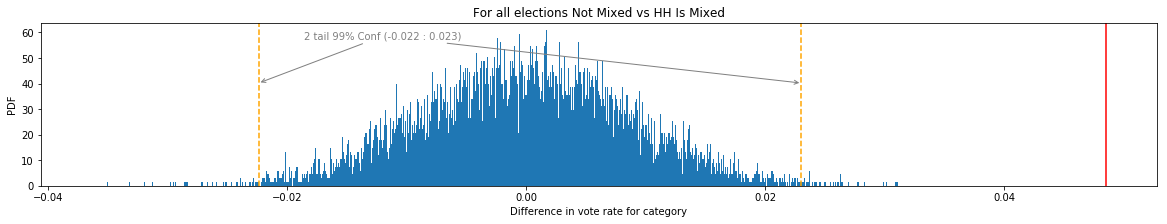

In [57]:
# Run Stats
(kx, dx),(ky, dy) = df_s.groupby(['mixedAfflsInHH'])
fig, axes = plt.subplots(figsize=(20,3))

kx = 'HH Is Mixed' if kx else 'Not Mixed'
ky = 'HH Is Mixed' if kx else 'Not Mixed'

df = pd.DataFrame(columns=outcols)
sx,nx,rx,sy,ny,ry = get_two_sample_ns(dx, dy)
cz,cp = props.proportions_ztest([sx,sy], [nx,ny], alternative='two-sided')
pp, emp_diff, axes = two_sample_perm_test_diff_frac_votes(dx,dy,axes,
                                                         'all elections {} vs {}'.format(kx,ky), tail=2)   
df.loc['All elections: '+kx+':'+ky, outcols] = [sx,nx,rx,sy,ny,ry,emp_diff*100,cz,cp,pp]
    
display(df)
plt.show()

Living in a household with people who are affiliated with another party meant you were $4.9\%$ (SS at 99%) less likely to vote than if you lived in a household where all the voters in the household were affiliated with the same party. (NPP voters did not count as affiliated and single voter households were removed from the analysis)

Then looking at if the voters are uniformly affiliated ie with the same party or all NPP. This measure includes single voter households which are all by default 'uniformly' affiliated.

In [58]:
# Gather data
e = 'E78'
vs, f = [e+'_nVotesPct', e+'_nVotesPos', e+'_nVotes'],['uniformAffInHH']
df_w = clean_df(voters.loc[:,vs + f], f, vs)

df_g, df_s = df_w.loc[:,[e+'_nVotesPct']+f], df_w.loc[:,[e+'_nVotesPos',e+'_nVotes']+f]

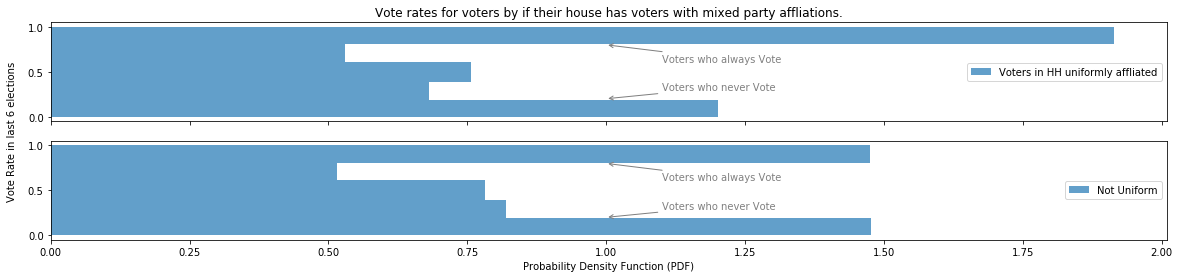

Number of Voters              \
           Voters in HH uniformly affliated Not Uniform   
Always                                 2477        1559   
Over Half                               722         574   
Half                                   1133         958   
Under Half                              927         912   
Never                                  1555        1561   
Totals                                 6814        5564   

                                  Voters as a %                  
           Voters in HH uniformly affliated_pct Not Uniform_pct  
Always                                     36.4            28.0  
Over Half                                  10.6            10.3  
Half                                       16.6            17.2  
Under Half                                 13.6            16.4  
Never                                      22.8            28.1  
Totals                                    100.0           100.0

In [59]:
# Summarize data
(k1, d1),(k0, d0) = df_g.groupby(['uniformAffInHH'])
df_w = pd.DataFrame({k0:d0[vs[0]],k1:d1[vs[0]]})
title = 'Vote rates for voters by if their house has voters with mixed party affliations.'
df = show_vote_rate_and_summary(df_w, ['Voters in HH uniformly affliated','Not Uniform'], title)

,votes_s0,elec_n0,rate_r0,votes_s1,elec_n1,rate_r1,emp_diff,calc_z,calc_p,perm_p
All elections: Not Uniform:HH Is Uniform,13029,27822,46.8298,17672,33208,53.2161,-6.38625,-15.7155,1.18489e-55,0


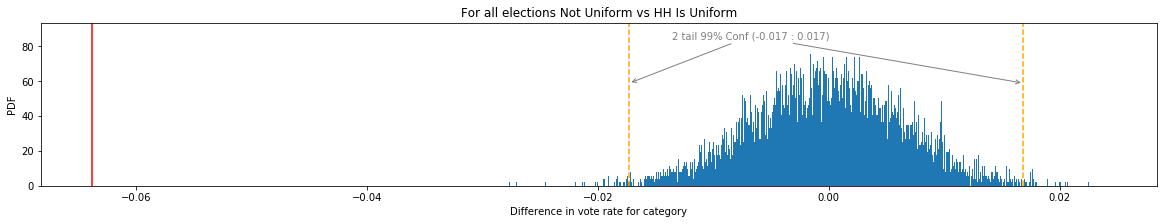

In [60]:
# Run Stats
(kx, dx),(ky, dy) = df_s.groupby(['uniformAffInHH'])
fig, axes = plt.subplots(figsize=(20,3))

kx = 'HH Is Uniform' if kx else 'Not Uniform'
ky = 'HH Is Uniform' if kx else 'Not Uniform'

df = pd.DataFrame(columns=outcols)
sx,nx,rx,sy,ny,ry = get_two_sample_ns(dx, dy)
cz,cp = props.proportions_ztest([sx,sy], [nx,ny], alternative='two-sided')
pp, emp_diff, axes = two_sample_perm_test_diff_frac_votes(dx,dy,axes,
                                                         'all elections {} vs {}'.format(kx,ky), tail=2)   
df.loc['All elections: '+kx+':'+ky, outcols] = [sx,nx,rx,sy,ny,ry,emp_diff*100,cz,cp,pp]
    
display(df)
plt.show()

Uniformly affliated households were $6.4\%$ more likely to vote than households with a mix of voters.